# **Transit Access Equity: Time-Aware Isochrones in the Bay Area**
**CYPLAN 101 — Group 4 (Track B: Advanced)**  
**Team:** Rabah Babaci & Adithya Ayanam  
**Mentor:** Metropolitan Transportation Commission (MTC)  
**Date:** December 2025  

---

## Project Overview
Many Bay Area neighborhoods—especially **Equity Priority Communities (EPCs)**—experience reduced transit access to employment opportunities during late-night and off-peak periods. Traditional accessibility measures often rely on peak-only indicators, masking inequities that emerge when service frequencies drop. This project, supported by MTC, evaluates how time-of-day differences impact job access for EPC residents.

The core story of this project is how transit service availability across the day produces unequal access to jobs, disproportionately affecting EPC communities.

**Research Questions**
- How does **transit job accessibility** differ between **AM peak** and **late-night** periods?  
- Which regions or demographic groups (especially EPCs) experience the largest off-peak reductions?  
- How can time-aware indicators inform service planning and scheduling improvements?

**Scope**
- **Geographic focus:** Alameda County (with Bay Area context)  
- **Temporal comparison:**  
  - **AM Peak:** 7:30–8:30  
  - **Late Night:** 22:00–23:00  
- **Equity focus:** EPC vs non-EPC census tracts  

**Datasets Used**

| Dataset          | Source             | Description                             |
|------------------|--------------------|-----------------------------------------|
| EPC Layer        | MTC Open Data      | Tract-level equity classifications      |
| ACS Demographics | U.S. Census API    | Socioeconomic indicators                |
| GTFS + OSM       | 511 SF Bay / MTC   | Transit schedules + multimodal network  |
| LODES Jobs       | LEHD               | Workplace job counts by tract           |

---

## 1. Environment Setup
This notebook relies on a consistent folder structure (`data/raw`, `data/processed`, `visualizations`, `results`, `docs`) and requires a working Java installation for **r5py**, which interfaces with the R5 routing engine.

In [1]:
# Python libraries. Java (JDK 21) is required for r5py.
import os
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Patch
import folium
from folium import LayerControl, FeatureGroup, Marker, Popup
from datetime import datetime, date, time, timedelta
from shapely.geometry import MultiPoint
import seaborn as sns
import warnings
import plotly.express as px

# External tools
import jpype
import r5py
from census import Census
from us import states
import zipfile
import requests

# PROJECT_ROOT = repository root (assuming notebooks/ is one level below)
PROJECT_ROOT = Path.cwd().parent

RAW = PROJECT_ROOT / "data" / "raw"
PROCESSED = PROJECT_ROOT / "data" / "processed"
VIS = PROJECT_ROOT / "visualizations"
RESULTS = PROJECT_ROOT / "results"
DOCS = PROJECT_ROOT / "docs"

# Ensure reproducible directory structure
for path in [RAW, PROCESSED, VIS, RESULTS, DOCS]:
    os.makedirs(path, exist_ok=True)

print("Folder structure verified\n")

# R5 routing engine requires a running JVM; r5py will start one if needed.
if jpype.isJVMStarted():
    print("Java (JVM) is running for r5py")
else:
    print("JVM not started. Ensure JDK 21 is installed and configured for r5py")

print("\nEnvironment setup complete")

Folder structure verified

Java (JVM) is running for r5py

Environment setup complete


In [2]:
# Suppress only deprecation warnings for cleaner notebook output
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Data Sources & Description

| Dataset | Description | Format | Source |
|--------|-------------|--------|--------|
| **EPC Layer** | Equity Priority Communities (Plan Bay Area 2050) | GeoJSON | MTC Open Data |
| **Census Tracts** | Alameda County tract geometries | Shapefile | US Census TIGER/Line (2022) |
| **ACS Demographics** | Population & socioeconomic attributes (2018–2022 5-year) | CSV / API | US Census API |
| **GTFS Feeds** | Bay Area transit schedules (weekday service) | ZIP | 511 SF Bay Open Data |
| **OSM Network** | Multimodal street + walking network for routing | PBF | OpenStreetMap |
| **LODES Jobs** | Workplace job counts by census tract | CSV | LEHD |

**Coverage & Granularity:**  
Although source datasets cover the full Bay Area, this workflow extracts and processes **Alameda County** tracts only.  
The EPC dataset covers **all Bay Area census tracts (n = 1,582)** and is later spatially joined to Alameda tracts.

**CRS Note:**  
- EPC Layer CRS: **EPSG:4326**  
- TIGER/Line Tracts CRS: **EPSG:4269**  
These are functionally compatible geographic coordinate systems but will be aligned to a common CRS before spatial operations.

**Dark / Missing Data Note:**  
Before cleaning, we validate each dataset for missing GEOIDs, null geometries, and inconsistent identifiers. These diagnostics support later limitations related to dark data and data sparsity.

**Goal:**  
Load, validate, and document all spatial datasets used in the accessibility workflow.

In [3]:
# Load Base Spatial Datasets

# EPC Layer (GeoJSON from MTC)
epc_url = (
    "https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/"
    "communities_of_concern_2020_acs2018/FeatureServer/0/query"
    "?outFields=*&where=1%3D1&f=geojson"
)
epc_path = RAW / "epc_layer.geojson"

# Download EPC if not already present (ensures reproducibility)
if not epc_path.exists() or epc_path.stat().st_size < 500:
    print(f"Downloading EPC GeoJSON...\n→ {epc_url}")
    response = requests.get(epc_url)
    response.raise_for_status()
    with open(epc_path, "wb") as f:
        f.write(response.content)
    print(f"EPC downloaded and saved to: {epc_path}")
else:
    print(f"EPC file already exists: {epc_path}")

# Load EPC
EPC = gpd.read_file(epc_path)
print(f"Loaded EPC: {len(EPC)} rows, {len(EPC.columns)} columns")


# TIGER/Line census tracts (2022)
zip_path = RAW / "tl_2022_06_tract.zip"
tiger_url = "https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_06_tract.zip"

# Download tracts if missing
if not zip_path.exists() or zip_path.stat().st_size < 1000:
    print(f"Downloading TIGER/Line tracts to {zip_path}...")
    response = requests.get(tiger_url, stream=True)
    response.raise_for_status()
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")
else:
    print(f"ZIP file exists: {zip_path}")

# Read tracts
try:
    tracts = gpd.read_file(f"zip://{zip_path}")
except Exception:
    # Rare fallback if zip:// reader fails
    extract_path = RAW / "tl_2022_06_tract"
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    shp_file = [f for f in os.listdir(extract_path) if f.endswith(".shp")][0]
    tracts = gpd.read_file(extract_path / shp_file)

# Filter for Alameda County (FIPS = 001)
tracts = tracts[tracts["COUNTYFP"] == "001"]
print(f"Loaded Alameda tracts: {len(tracts)} rows")


# ACS Demographics (via Census API)
from dotenv import load_dotenv
load_dotenv()  # Loads API key from local .env file (not committed)

census_api_key = os.getenv("CENSUS_API_KEY")
if not census_api_key:
    raise ValueError("Census API key not found. Add it to your .env file.")

c = Census(census_api_key)

raw_acs_file = RAW / "acs_population.csv"
processed_acs_file = PROCESSED / "acs_population_clean.csv"

# Use cached ACS extract if available for reproducibility
if raw_acs_file.exists():
    print(f"ACS file exists: {raw_acs_file}. Loading.")
    acs = pd.read_csv(raw_acs_file)
else:
    print("Fetching ACS 5-year data for Alameda County...")
    try:
        acs_data = c.acs5.state_county_tract(
            (
                "B01001_001E",  # Total Population
                "B19013_001E",  # Median household income
                "B23025_005E",  # Unemployed population
            ),
            states.CA.fips,  # California
            "001",  # Alameda County
            Census.ALL,
        )
        acs = pd.DataFrame(acs_data).rename(
            columns={
                "state": "StateFIPS",
                "county": "CountyFIPS",
                "tract": "TractFIPS",
                "B01001_001E": "Total_Population",
                "B19013_001E": "Median_Income",
                "B23025_005E": "Unemployed_Pop",
            }
        )
        acs.to_csv(raw_acs_file, index=False)
        print(f"Saved raw ACS extract: {raw_acs_file}")
    except Exception as e:
        raise Exception(f"Failed to fetch ACS data: {e}")

# Save processed ACS file
acs.to_csv(processed_acs_file, index=False)
print(f"Processed ACS data saved → {processed_acs_file}")


# Validations
print("\nDataset validation:")
print(f"EPC rows: {len(EPC)} | Columns: {len(EPC.columns)}")
print(f"Tracts rows: {len(tracts)} | Columns: {len(tracts.columns)}")
print(f"ACS rows: {len(acs)} | Columns: {len(acs.columns)}")

print("\nNull checks (pre-cleaning):")

# Detect GEOID column in EPC
epc_geoid_col = None
for col in EPC.columns:
    if col.lower() in ["geoid", "geoid10", "geoid20"]:
        epc_geoid_col = col
        break

if epc_geoid_col is None:
    raise ValueError("GEOID column not found in EPC layer.")

print("EPC GEOID column detected:", epc_geoid_col)

print("EPC:", EPC[[epc_geoid_col, "geometry"]].isnull().sum())
print("Tracts:", tracts[["GEOID", "geometry"]].isnull().sum())
print("ACS:", acs[["StateFIPS", "CountyFIPS", "TractFIPS", "Total_Population"]].isnull().sum())

print("\nCRS check:")
print("EPC CRS:", EPC.crs)
print("Tracts CRS:", tracts.crs)

# Save quick summary
summary_path = PROCESSED / "data_summary.txt"
with open(summary_path, "w") as f:
    f.write(
        f"EPC rows: {len(EPC)}\n"
        f"Tracts rows: {len(tracts)}\n"
        f"ACS rows: {len(acs)}\n"
    )

print(f"\nSummary saved to {summary_path}")

EPC file already exists: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/raw/epc_layer.geojson
Loaded EPC: 1582 rows, 43 columns
ZIP file exists: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/raw/tl_2022_06_tract.zip
Loaded Alameda tracts: 379 rows
ACS file exists: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/raw/acs_population.csv. Loading.
Processed ACS data saved → /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/processed/acs_population_clean.csv

Dataset validation:
EPC rows: 1582 | Columns: 43
Tracts rows: 379 | Columns: 13
ACS rows: 379 | Columns: 8

Null checks (pre-cleaning):
EPC GEOID column detected: geoid
EPC: geoid       0
geometry    0
dtype: int64
Tracts: GEOID       0
geometry    0
dtype: int64
ACS: StateFIPS           0
CountyFIPS          0
TractFIPS           0
Total_Population    0
dtype: int64

CRS check:
EPC CRS: EPSG:4326
Tracts CRS: EPSG:4269

Summary saved to /Users/rabahbabaci/Developement/MTC-Tra

### Missing Data Summary (Dark Data Classification)

| Dataset | Missingness Type | Explanation | Handling Strategy |
|---------|------------------|-------------|-------------------|
| **EPC Layer** | Structural | The EPC dataset includes all Bay Area tracts; missing EPC classification within Alameda arises only after spatial filtering, not from attribute loss | Treat tracts without EPC designation as non-EPC after verifying boundaries and geometry |
| **TIGER Tracts** | MCAR | Occasional tracts may have invalid or empty geometries due to TIGER extraction quirks, unrelated to socioeconomic characteristics | Drop rows with null or invalid geometry if encountered |
| **ACS Demographics** | MNAR | ACS suppresses or perturbs values for sparsely populated tracts; missingness depends on tract characteristics and therefore is not random | Flag suppressed values; avoid imputation; propagate missingness forward into analysis transparently |

These checks ensure consistent GEOIDs, aligned CRS, valid geometries, and interpretable demographic fields before proceeding to cleaning and analysis. The classification supports later reflection on dark data, ecological fallacies, and interpretability (Week 13).

----

## 3. Data Cleaning & Processing

**Purpose:**  
Prepare a tract-level dataset for Alameda County by standardizing GEOIDs, merging EPC designations and ACS population fields, and aligning geometries to a common CRS. This intermediate dataset supports both the midterm exploratory analysis and the final time-aware accessibility workflow.

**Tasks:**  
- Filter TIGER/Line tracts to Alameda County  
- Standardize all GEOIDs to 11-digit strings  
- Merge EPC flags and ACS population fields  
- Flag suppressed or missing ACS population values  
- Ensure geometries share a consistent CRS (final reprojection in Section 4)  
- Save intermediate outputs for verification and reproducibility

In [4]:
# Filter to Alameda County
alameda_tracts = tracts[tracts["COUNTYFP"] == "001"].copy()

# Standardize GEOIDs (11-digit strings)
alameda_tracts["GEOID"] = alameda_tracts["GEOID"].astype(str).str.zfill(11)
acs["GEOID"] = (
    acs["StateFIPS"].astype(str).str.zfill(2)
    + acs["CountyFIPS"].astype(str).str.zfill(3)
    + acs["TractFIPS"].astype(str).str.zfill(6)
)

# Rename EPC GEOID column
EPC = EPC.rename(columns={"geoid": "GEOID"})
EPC["GEOID"] = EPC["GEOID"].astype(str).str.zfill(11)

# EPC classification
EPC["epc_class"] = EPC["epc_class"].astype(str).str.lower()
print("EPC class distribution:", EPC["epc_class"].value_counts().to_dict())

# Explicitly treat "high", "higher", "highest" as EPC; all others (incl. "na") are non-EPC
EPC["is_epc"] = EPC["epc_class"].isin(["high", "higher", "highest"]).astype(int)

# Slim datasets
if EPC["GEOID"].duplicated().sum() > 0:
    print(f"Warning: {EPC['GEOID'].duplicated().sum()} duplicate GEOIDs in EPC")

EPC_slim = EPC[["GEOID", "is_epc"]].drop_duplicates("GEOID")

acs_slim = (
    acs[["GEOID", "Total_Population"]]
    .copy()
    .rename(columns={"Total_Population": "population"})
)

# Merge datasets
merged = alameda_tracts.merge(EPC_slim, on="GEOID", how="left").merge(
    acs_slim, on="GEOID", how="left"
)

# Missingness flags
merged["is_epc"] = merged["is_epc"].fillna(0).astype(int)
merged["population_missing"] = merged["population"].isnull().astype(int)

# Fill NA for technical completeness (interpretation handled via population_missing)
merged["population"] = merged["population"].fillna(0)

# Reproject to EPSG:4326 for consistency with downstream routing & mapping
merged = merged.to_crs(epsg=4326)

# Validate merged data
print("Merged validation:")
print(f"Rows: {len(merged)}, CRS: {merged.crs}, Columns: {merged.columns.tolist()}")
print(
    f"Nulls:\n{merged[['GEOID', 'is_epc', 'population', 'population_missing']].isnull().sum()}"
)
print(
    f"Common GEOIDs (tracts & ACS): {len(set(alameda_tracts['GEOID']) & set(acs['GEOID']))}"
)
print(f"EPC tracts (after merge): {merged['is_epc'].sum()} out of {len(merged)}")
print(f"Population range: {merged['population'].min()} to {merged['population'].max()}")
print(f"EPC distribution: {merged['is_epc'].value_counts().to_dict()}")
print(f"Valid geometries: {merged['geometry'].is_valid.sum()}/{len(merged)}")
print("Zero-population tracts:", len(merged[merged["population"] == 0]))

# Save outputs
try:
    merged.to_file(PROCESSED / "alameda_tracts_clean.geojson", driver="GeoJSON")
    print(f"Saved: {PROCESSED}/alameda_tracts_clean.geojson")
except Exception as e:
    print(f"Error saving processed file: {e}")

EPC class distribution: {'na': 1243, 'high': 156, 'higher': 105, 'highest': 78}
Merged validation:
Rows: 379, CRS: EPSG:4326, Columns: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'is_epc', 'population', 'population_missing']
Nulls:
GEOID                 0
is_epc                0
population            0
population_missing    0
dtype: int64
Common GEOIDs (tracts & ACS): 379
EPC tracts (after merge): 97 out of 379
Population range: 0.0 to 12521.0
EPC distribution: {0: 282, 1: 97}
Valid geometries: 379/379
Zero-population tracts: 2
Saved: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/processed/alameda_tracts_clean.geojson


### Missing Data & Dark Data Note

After merging, no ACS population fields were missing for Alameda County tracts in this extract (`population_missing = 0` for all rows). However, two tracts report a population value of zero. These are true zero-population areas (e.g., industrial or open-space zones), not suppressed or missing ACS values, and should not be treated as dark data.

Although missingness was not present in this particular pull, the flag `population_missing` is preserved in the dataset to support transparency and to accommodate future ACS updates where MNAR suppression may occur for sparsely populated tracts.

This distinction—true zeros vs. missing or suppressed values—is important for avoiding ecological fallacies and misinterpretation in later stages of the analysis.

---

## 4. Clean Dataset Assembly

**Purpose:**  
Build the final tract-level GeoDataFrame for Alameda County containing the core variables needed for visualization and the time-aware accessibility analysis. This step finalizes the CRS, selects essential fields, and carries forward the `population_missing` flag for transparency.

**Tasks:**  
- Select required columns from the merged dataset  
- Confirm all geometries use a consistent CRS (finalized at EPSG:4326)  
- Validate the dataset (rows, CRS, nulls, EPC distribution)  
- Preserve `population_missing` to track potential ACS suppression or gaps  
- Save the final cleaned dataset for visualization and analysis

In [5]:
# Select required columns for downstream analysis and mapping
clean_gdf = merged[
    ["GEOID", "is_epc", "population", "population_missing", "geometry"]
].copy()

# Validate
print("Clean dataset validation:")
print(f"Rows: {len(clean_gdf)}, CRS: {clean_gdf.crs}")
print(f"Nulls:\n{clean_gdf[['GEOID', 'is_epc', 'population']].isnull().sum()}")
print(f"EPC distribution:\n{clean_gdf['is_epc'].value_counts()}")
print(
    f"Population range: {clean_gdf['population'].min()} to {clean_gdf['population'].max()}"
)
print(f"Valid geometries: {clean_gdf['geometry'].is_valid.sum()}/{len(clean_gdf)}")
print(f"Zero-population tracts: {len(clean_gdf[clean_gdf['population'] == 0])}")

# Confirm population_missing carried over correctly
print(
    "Zero-population due to missing ACS data:",
    clean_gdf.loc[clean_gdf["population"] == 0, "population_missing"].sum(),
)

# Save final dataset (analysis-ready tract layer)
try:
    clean_gdf.to_file(PROCESSED / "alameda_final.geojson", driver="GeoJSON")
    print(f"Saved: {PROCESSED}/alameda_final.geojson")
except Exception as e:
    print(f"Error saving {PROCESSED}/alameda_final.geojson: {e}")

Clean dataset validation:
Rows: 379, CRS: EPSG:4326
Nulls:
GEOID         0
is_epc        0
population    0
dtype: int64
EPC distribution:
is_epc
0    282
1     97
Name: count, dtype: int64
Population range: 0.0 to 12521.0
Valid geometries: 379/379
Zero-population tracts: 2
Zero-population due to missing ACS data: 0
Saved: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/processed/alameda_final.geojson


### Clean Dataset Summary

The final `alameda_final.geojson` contains 379 Alameda County census tracts with EPC flags, population attributes, and a `population_missing` indicator carried over from the ACS merge. All geometries are valid and the dataset is stored in EPSG:4326 after resolving the earlier TIGER (EPSG:4269) vs. EPC (EPSG:4326) CRS mismatch.

In this extract, two tracts report a population value of zero, and none are flagged as missing (`population_missing = 0` for all rows). These zero values represent true zero-population areas rather than suppressed ACS estimates, but the missingness flag is preserved for transparency and to support future updates.

This cleaned layer serves as the base dataset for the midterm interactive map and for the final phase of the project, including time-aware travel-time calculations and isochrone-based accessibility analysis.

---

## 5. Interactive Map (Midterm Deliverable)

**Purpose:**  
Visualize Equity Priority Communities (EPCs) and non-EPC tracts in Alameda County using the cleaned dataset from Section 4. This interactive map provides hover-tooltips for GEOID, population, and EPC classification.

**Requirements:**  
- Clear title and data source citation  
- Color differentiation for EPC vs. non-EPC tracts  
- Interactive hover tooltips  
- Exportable HTML output for use in the midterm and final project website  

In [6]:
# Add human-readable EPC label
clean_gdf["EPC_Label"] = clean_gdf["is_epc"].map({1: "EPC", 0: "Non-EPC"})

# Initialize map centered on Alameda County
m = folium.Map(
    location=[37.77, -122.23],
    zoom_start=10,
    tiles="cartodbpositron",
    control_scale=True,
)

# Add EPC vs. non-EPC polygons
folium.GeoJson(
    clean_gdf,
    name="Alameda County Tracts",
    style_function=lambda x: {
        "fillColor": "#d7191c" if x["properties"]["is_epc"] == 1 else "#2b83ba",
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID", "population", "EPC_Label"],
        aliases=["GEOID", "Population", "EPC status"],
        localize=True,
    ),
).add_to(m)


# Title + caption (shifted to avoid covering controls)
title_html = """
<div style="
    position: fixed; 
    top: 10px; left: 60px; 
    z-index: 9999;
    background-color: white; 
    padding: 12px; 
    border: 1px solid black;
    max-width: 520px;
">
    <h4>Equity Priority Communities (2020 / ACS 2018–2022) — Alameda County, CA</h4>
    <p style="font-size: 12px;">
        Data Sources: MTC Plan Bay Area 2050 (EPC), US Census TIGER/Line 2022 (tracts), ACS 2018–2022 (population).
        This map highlights Equity Priority Communities (EPCs) in red and non-EPC tracts in blue.
    </p>
</div>
"""
m.get_root().html.add_child(folium.Element(title_html))


# Accessible legend with background-color boxes
legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; 
    z-index: 9999;
    background-color: white; 
    padding: 10px; 
    border: 1px solid black;
">
    <strong>Legend</strong><br>
    <div style="margin-top: 5px;">
        <span style="display:inline-block; width:14px; height:14px; background:#d7191c; margin-right:6px;"></span>
        EPC Tracts
    </div>
    <div style="margin-top: 5px;">
        <span style="display:inline-block; width:14px; height:14px; background:#2b83ba; margin-right:6px;"></span>
        Non-EPC Tracts
    </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl().add_to(m)

# Save map
map_path = VIS / "epc_map.html"
m.save(map_path)
print(f"Saved to {map_path}")

m

Saved to /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/visualizations/epc_map.html


### Interactive Map Summary

The exported `epc_map.html` provides an interactive view of EPC and non-EPC tracts in Alameda County. EPC tracts appear in red and non-EPC tracts in blue, with hover-tooltips showing GEOID, population, and EPC status. The layer is built from the cleaned dataset (`alameda_final.geojson`) and satisfies the midterm requirement for an interactive visualization while also serving as a base map for the project website.

---

## 6. Pilot Accessibility Metric

This section prepares the job counts needed for the pilot accessibility calculation by loading and aggregating tract-level employment from the LODES Workplace Area Characteristics (WAC) dataset. This step does not compute travel times; it simply establishes the total number of jobs located in each census tract, which will later be used to evaluate reachable employment under different travel-time thresholds.

### 6.1 Data Loading and Preparation

We download and aggregate the 2021 LODES WAC (S000/JT00) file to obtain total workplace jobs per census tract. Because LODES suppresses job counts for tracts with extremely low employment or no workers, the WAC table includes **378** Alameda County tracts rather than the **379** found in TIGER/ACS. This is expected structural missingness and not a data error.

These job totals form the basis for the pilot accessibility metric in the next section.


In [7]:
# Download LODES WAC from URL
wac_path = RAW / "ca_wac_S000_JT00_2021.csv.gz"
wac_url = (
    "https://lehd.ces.census.gov/data/lodes/LODES8/ca/wac/ca_wac_S000_JT00_2021.csv.gz"
)

if not wac_path.exists() or wac_path.stat().st_size < 1000:
    print(f"Downloading LODES WAC to {wac_path}...")
    r = requests.get(wac_url, stream=True)
    if r.status_code == 200:
        with open(wac_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded: {wac_path}, Size: {os.path.getsize(wac_path)} bytes")
    else:
        raise Exception(f"Failed to download WAC: HTTP {r.status_code}")
else:
    print(f"WAC file exists: {wac_path}, Size: {os.path.getsize(wac_path)} bytes")

# Load and aggregate LODES WAC jobs
wac = pd.read_csv(wac_path, compression="gzip", dtype={"w_geocode": "string"})

print(
    "Unique county FIPS codes in WAC data:", wac["w_geocode"].str.slice(0, 5).unique()
)

# GEOID = workplace tract code (11-digit)
wac["GEOID"] = wac["w_geocode"].str.slice(0, 11)

# Aggregate across job categories (S000 = all workers)
jobs = (
    wac.groupby("GEOID", as_index=False)["C000"].sum().rename(columns={"C000": "jobs"})
)

# quick validation
alameda_jobs = jobs[jobs["GEOID"].str.startswith("06001")]
print(f"Alameda County tracts in jobs table: {len(alameda_jobs)}")
print(alameda_jobs.describe())

WAC file exists: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/raw/ca_wac_S000_JT00_2021.csv.gz, Size: 6000959 bytes
Unique county FIPS codes in WAC data: <StringArray>
['06001', '06003', '06005', '06007', '06009', '06011', '06013', '06015',
 '06017', '06019', '06021', '06023', '06025', '06027', '06029', '06031',
 '06033', '06035', '06037', '06039', '06041', '06043', '06045', '06047',
 '06049', '06051', '06053', '06055', '06057', '06059', '06061', '06063',
 '06065', '06067', '06069', '06071', '06073', '06075', '06077', '06079',
 '06081', '06083', '06085', '06087', '06089', '06091', '06093', '06095',
 '06097', '06099', '06101', '06103', '06105', '06107', '06109', '06111',
 '06113', '06115']
Length: 58, dtype: string
Alameda County tracts in jobs table: 378
               jobs
count    378.000000
mean    2029.603175
std     4377.354929
min        7.000000
25%      365.750000
50%      679.500000
75%     1636.000000
max    51144.000000


### LODES WAC Summary

The WAC dataset contains workplace job totals for **378** Alameda County tracts. The one missing tract does not represent a data error: LODES suppresses or omits job counts for tracts with zero employment or very small workplaces, making this a form of structural missingness.

Total jobs range from **7** to **≈ 51,000**, reflecting major employment clusters along the Oakland–Berkeley–Emeryville corridor and lower-employment tracts in suburban or residential areas.

These job totals are merged onto the cleaned tract dataset in Section 6.2 to support the pilot accessibility calculation.

---

### 6.2 Merge, Compute Accessibility, and Summarize

We merge tract-level job totals from LODES onto the cleaned Alameda tract layer and compute a simple, distance-based accessibility proxy. For each tract, we estimate the number of jobs located within a 30-minute radius assuming a constant travel speed of **40 km/h**. Centroids are computed in **UTM Zone 10N** to ensure metric distance calculations.

This baseline method is intentionally simplistic. It:

- uses straight-line (Euclidean) distance rather than the street or transit network  
- assumes constant travel speed and no congestion  
- includes jobs located within the same tract (distance = 0)  
- fills the single missing WAC tract with `jobs = 0`, representing structural non-employment  

Because EPCs are concentrated near the Oakland–Berkeley job core, they show higher estimated job accessibility in this preliminary metric.

This proxy will be replaced by network-based, time-aware accessibility measures using R5 in the final stage of the project.


In [8]:
# Use clean_gdf from Section 4
tracts_jobs = clean_gdf.copy()
print(
    "Unique county FIPS codes in clean_gdf:",
    clean_gdf["GEOID"].str.slice(0, 5).unique(),
)

# Merge jobs onto tract layer (fill missing tracts with jobs=0)
tracts_jobs = tracts_jobs.merge(jobs, on="GEOID", how="left").fillna({"jobs": 0})

# Compute centroids in UTM for accurate Euclidean distance
tracts_jobs = tracts_jobs.to_crs(26910)
tracts_jobs["centroid"] = tracts_jobs.geometry.centroid.copy()
tracts_jobs["x"] = tracts_jobs["centroid"].x
tracts_jobs["y"] = tracts_jobs["centroid"].y

# Prepare arrays
X = tracts_jobs[["x", "y"]].to_numpy()
J = tracts_jobs["jobs"].to_numpy()

# Pairwise distances (km)
dx = X[:, 0][:, None] - X[:, 0][None, :]
dy = X[:, 1][:, None] - X[:, 1][None, :]
dist_km = np.sqrt(dx**2 + dy**2) / 1000.0

# Convert threshold to time (min)
speed_kmh = 40.0
threshold_min = 30.0
time_min = (dist_km / speed_kmh) * 60.0

# Binary reachability matrix
mask = time_min <= threshold_min

# Compute accessible jobs
tracts_jobs["jobs_30min"] = mask.dot(J).astype(int)

# Summary by EPC
summary = (
    tracts_jobs.groupby("is_epc")["jobs_30min"]
    .agg(["count", "mean", "median", "min", "max"])
    .rename(index={0: "Non-EPC", 1: "EPC"})
)

print("Summary:")
print(summary)

# reset geometry to original field
tracts_jobs = tracts_jobs.set_geometry("geometry")

Unique county FIPS codes in clean_gdf: ['06001']
Summary:
         count           mean    median     min     max
is_epc                                                 
Non-EPC    282  344051.556738  365831.0   53305  488078
EPC         97  419216.865979  421795.0  321849  482405


### Accessibility Metric Summary

This pilot metric estimates the number of jobs reachable within a 30-minute radius at a constant speed of 40 km/h. EPC tracts show higher baseline accessibility (mean ≈ 419k jobs) than non-EPC tracts (mean ≈ 344k jobs), reflecting their proximity to dense employment centers in Oakland, Emeryville, and Berkeley.

Because this method uses straight-line distances and assumes uniform travel speed, it **overestimates** job access and should not be interpreted as a real accessibility measure. It serves only as a baseline before applying time-aware, network-based routing with R5.

---

### 6.3 Distribution Visualization

To compare how estimated job accessibility differs between EPC and non-EPC tracts, we visualize the distribution of jobs reachable within 30 minutes using a violin plot. Unlike a boxplot, a violin plot shows the full distribution shape—including density, skewness, and variability—making it easier to see how accessibility patterns differ between groups in this preliminary, distance-based metric.


Violin plot saved to: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/visualizations/jobs30_violin.png


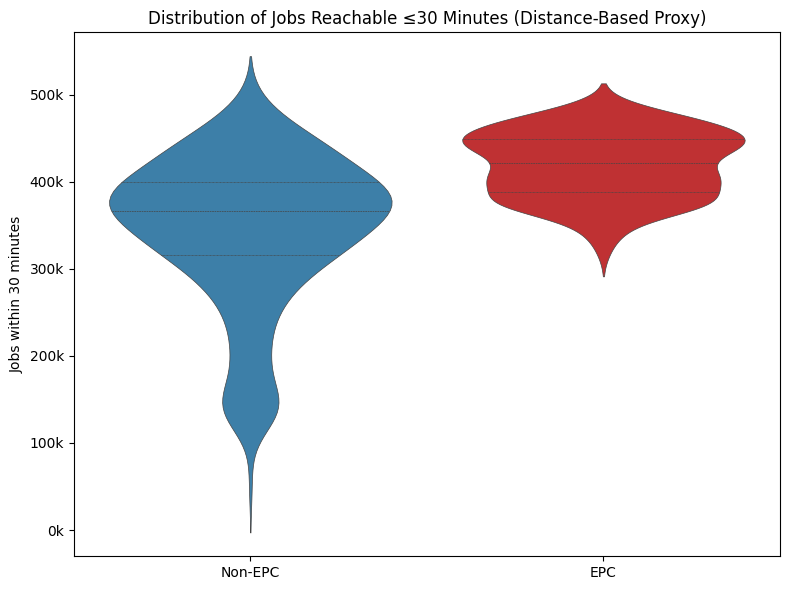

In [9]:
# Prepare DataFrame for Seaborn
plot_df = tracts_jobs[["jobs_30min", "is_epc"]].copy()
plot_df["EPC Status"] = plot_df["is_epc"].map({1: "EPC", 0: "Non-EPC"})

plt.figure(figsize=(8, 6))

sns.violinplot(
    data=plot_df,
    x="EPC Status",
    y="jobs_30min",
    hue="EPC Status",  # ensures palette is applied correctly
    palette={"EPC": "#d7191c", "Non-EPC": "#2b83ba"},
    inner="quartile",
    linewidth=0.5,
    legend=False,  # prevents duplicate legend entries
)

plt.title("Distribution of Jobs Reachable ≤30 Minutes (Distance-Based Proxy)")
plt.ylabel("Jobs within 30 minutes")
plt.xlabel("")

# Format y-axis in thousands
formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()

# Save visual
violin_path = VIS / "jobs30_violin.png"
plt.savefig(violin_path, dpi=180)
print(f"Violin plot saved to: {violin_path}")

plt.show()

### Violin Plot Interpretation

The violin plot illustrates clear distributional differences in estimated job accessibility between EPC and non-EPC tracts. EPC tracts cluster more tightly around higher accessibility values (roughly 400k–450k reachable jobs), reflecting their proximity to dense employment areas in Oakland, Emeryville, and Berkeley. In contrast, non-EPC tracts show a wider and more uneven distribution with a long lower tail, corresponding to suburban and exurban areas farther from major job centers.

Because this metric is based on straight-line (Euclidean) distances and an assumed travel speed, it should be interpreted only as a conceptual baseline rather than a real measure of transit accessibility. The final phase of the project replaces this proxy with time-aware, network-based accessibility estimates generated using the R5 routing engine.

---

### 6.4 Choropleth Visualization

Choropleth saved to: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/visualizations/jobs30_map.png


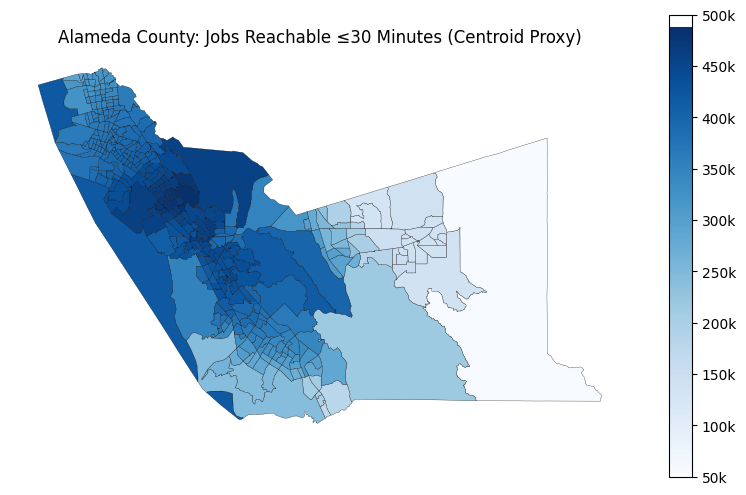

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

chor = tracts_jobs.to_crs(4326).plot(
    column="jobs_30min",
    cmap="Blues",
    edgecolor="k",
    linewidth=0.2,
    ax=ax,
    legend=False,
)

# Create a manual colorbar that we can fully control
sm = plt.cm.ScalarMappable(
    cmap="Blues",
    norm=plt.Normalize(
        vmin=tracts_jobs["jobs_30min"].min(), vmax=tracts_jobs["jobs_30min"].max()
    ),
)
sm._A = []  # required hack for older Matplotlib versions
cbar = plt.colorbar(sm, ax=ax)

# Format ticks in 'k' (thousands)
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(t/1000)}k" for t in ticks])

ax.set_title("Alameda County: Jobs Reachable ≤30 Minutes (Centroid Proxy)")
ax.set_axis_off()

# Save and show
choropleth_path = VIS / "jobs30_map.png"
plt.savefig(choropleth_path, dpi=180, bbox_inches="tight")
print(f"Choropleth saved to: {choropleth_path}")

plt.show()

### Choropleth Interpretation

To make this map easier to read for non-technical audiences, we use a simple
sequential colormap (“Blues”), where darker shades show tracts with higher estimated
job accessibility. Areas along the Berkeley–Oakland–San Leandro corridor appear
darkest, reflecting strong access to employment centers. Lighter tracts toward eastern
Alameda County have lower accessibility under the centroid-distance model. This visual
pattern will later be compared with time-specific R5 isochrones.

Because this measure uses straight-line distances rather than network travel times,
it tends to overestimate accessibility and serves only as a baseline before applying
full R5-based isochrone analysis. This spatial pattern motivates the need for a network-based, time-of-day-aware routing engine (R5), since real transit travel times vary significantly between peak and late-night periods.

---

### 6.5 Bar Char Visualization

Bar chart saved to: /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/visualizations/jobs30_bar_chart.png


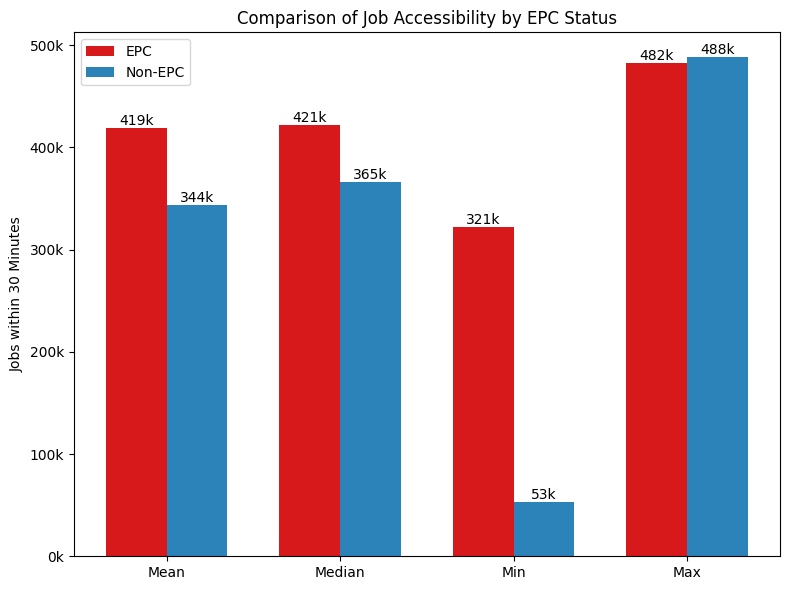

In [11]:
# Bar Chart of Summary Statistics (Displayed Inline and Saved)

categories = ["Mean", "Median", "Min", "Max"]
epc_values = [
    summary.loc["EPC", "mean"],
    summary.loc["EPC", "median"],
    summary.loc["EPC", "min"],
    summary.loc["EPC", "max"],
]
non_epc_values = [
    summary.loc["Non-EPC", "mean"],
    summary.loc["Non-EPC", "median"],
    summary.loc["Non-EPC", "min"],
    summary.loc["Non-EPC", "max"],
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width / 2, epc_values, width, label="EPC", color="#d7191c")
bars2 = ax.bar(x + width / 2, non_epc_values, width, label="Non-EPC", color="#2b83ba")

ax.set_ylabel("Jobs within 30 Minutes")
ax.set_title("Comparison of Job Accessibility by EPC Status")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height/1000)}k",
            ha="center",
            va="bottom",
        )

# format y-axis ticks using a FixedLocator to avoid warnings
yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([f"{int(y/1000)}k" for y in yticks])

plt.tight_layout()

# Save and show
bar_chart_path = VIS / "jobs30_bar_chart.png"
plt.savefig(bar_chart_path, dpi=180)
print(f"Bar chart saved to: {bar_chart_path}")

plt.show()

### Bar Chart Interpretation

This bar chart summarizes how the centroid-based accessibility metric compares
between EPC and non-EPC tracts across four reference statistics (mean, median,
minimum, and maximum). Values are shown in thousands (`k`) for readability.  
EPC tracts exhibit higher mean and median accessibility, while non-EPC tracts show
greater variability and a substantially lower minimum value. This reflects the fact
that EPC areas, on average, lie closer to core employment centers in the inner East
Bay under the simplified distance-based model.

However, because this proxy relies on straight-line distances and an assumed travel
speed, it should be interpreted only as a preliminary indicator. The final analysis
replaces this approach with network-based, time-aware travel times computed using the
R5 routing engine for AM Peak and Late-Night scenarios

---

### 7. Early Findings & Notes for Report
Use this section to summarize what you see on the map and in the data.  
Example bullets you might write:  
- EPC tracts cluster along Oakland and San Leandro corridors.  
- Non‑EPC tracts dominate eastern Alameda areas.  
- Population density varies strongly between groups.  

In [12]:
from IPython.display import Markdown, display
import textwrap, os

notes_md = textwrap.dedent(
    """
# 7. Early Findings & Notes

- **Spatial patterns (maps)**
  - EPC tracts cluster along the West County corridor (Berkeley → Oakland → San Leandro → Hayward), where transit services and job densities are highest.
  - Eastern Alameda County (Dublin, Pleasanton, Livermore) is overwhelmingly non-EPC and shows noticeably lower accessibility under the pilot metric.

- **Pilot accessibility results (jobs ≤ 30 minutes, centroid proxy)**
  - EPC tracts reach roughly **420k–450k jobs**, while non-EPC tracts average **340k–365k**.
  - *Interpretation:* Even in a simplified model, EPC tracts appear closer to major employment centers, which raises the question of how time-of-day service levels will change this relationship.

- **Population context**
  - EPC tracts tend to include older, denser urban neighborhoods.
  - Many non-EPC tracts in eastern Alameda County are lower-density and more auto-oriented, contributing to lower estimated accessibility.

- **Data joins & keys**
  - GEOIDs required consistent zero-padding (state–county–tract = 11 digits).
  - LODES WAC data required block → tract aggregation (`w_geocode` → first 11 digits; sum `C000`).
  - One Alameda tract shows no LODES employment (water/no-employment area), which is expected.

- **Planning takeaways (preliminary)**
  - High-access EPC corridors reflect proximity to concentrated job centers in Oakland and Berkeley.
  - Low-access non-EPC suburban tracts illustrate structural distance from employment hubs and may depend more heavily on car travel.
  - *These patterns must be re-evaluated with real transit travel times,* especially for **late-night** service where frequency drops sharply.

- **Method limitations (pilot metric only)**
  - Straight-line distances with a constant speed do not represent real transit or road travel.
  - Accessibility is overestimated compared to what we expect from network-based routing.
  - LODES 2021 may reflect post-COVID shifts in employment geography.
  - The final accessibility analysis will use **R5-based, time-specific travel times** (AM Peak and Late-Night).

- **Quality checks**
  - CRS standardized to EPSG:4326 for mapping and EPSG:26910 for distance calculations.
  - All geometries validated; EPC flags and ACS attributes merged cleanly.

## Quantitative Summary

| Group       | Tract Count | Mean Jobs ≤30 min | Median | Min  | Max  |
|------------:|------------:|------------------:|-------:|-----:|-----:|
| **EPC**     | 97          | 419k              | 422k   | 322k | 482k |
| **Non-EPC** | 282         | 344k              | 366k   | 53k  | 488k |

**Interpretation:**  
EPC tracts have access to **~75k more jobs** within 30 minutes under the centroid proxy (≈22% higher). This reflects their physical proximity to major job centers, not necessarily better transit service. The R5 analysis will test whether this advantage persists—or disappears—when using real scheduled transit travel times.

## Accessibility Distribution Interpretation
- EPC tracts show higher medians and a more compact range.
- Non-EPC tracts show wider variability and very low minimum values due to spatial distance from employment clusters.
- These early patterns help justify computing **time-aware isochrones** to understand how AM Peak vs Late-Night service affects accessibility gaps.

## Key Early Takeaway
EPC tracts show consistently high proximity-based accessibility, while non-EPC suburban tracts lag behind.  
**The next phase will evaluate whether these differences grow, shrink, or reverse when using R5-based travel times for AM Peak and Late-Night scenarios.**

**Data sources:**  
MTC Plan Bay Area 2050 (EPC), US Census TIGER/ACS 2022, LEHD LODES 2021 (WAC).

"""
)

display(Markdown(notes_md))

# Save markdown to results folder
os.makedirs(RESULTS, exist_ok=True)
with open(f"{RESULTS}/early_findings.md", "w", encoding="utf-8") as f:
    f.write(notes_md)

print("Saved findings summary to results/early_findings.md")


# 7. Early Findings & Notes

- **Spatial patterns (maps)**
  - EPC tracts cluster along the West County corridor (Berkeley → Oakland → San Leandro → Hayward), where transit services and job densities are highest.
  - Eastern Alameda County (Dublin, Pleasanton, Livermore) is overwhelmingly non-EPC and shows noticeably lower accessibility under the pilot metric.

- **Pilot accessibility results (jobs ≤ 30 minutes, centroid proxy)**
  - EPC tracts reach roughly **420k–450k jobs**, while non-EPC tracts average **340k–365k**.
  - *Interpretation:* Even in a simplified model, EPC tracts appear closer to major employment centers, which raises the question of how time-of-day service levels will change this relationship.

- **Population context**
  - EPC tracts tend to include older, denser urban neighborhoods.
  - Many non-EPC tracts in eastern Alameda County are lower-density and more auto-oriented, contributing to lower estimated accessibility.

- **Data joins & keys**
  - GEOIDs required consistent zero-padding (state–county–tract = 11 digits).
  - LODES WAC data required block → tract aggregation (`w_geocode` → first 11 digits; sum `C000`).
  - One Alameda tract shows no LODES employment (water/no-employment area), which is expected.

- **Planning takeaways (preliminary)**
  - High-access EPC corridors reflect proximity to concentrated job centers in Oakland and Berkeley.
  - Low-access non-EPC suburban tracts illustrate structural distance from employment hubs and may depend more heavily on car travel.
  - *These patterns must be re-evaluated with real transit travel times,* especially for **late-night** service where frequency drops sharply.

- **Method limitations (pilot metric only)**
  - Straight-line distances with a constant speed do not represent real transit or road travel.
  - Accessibility is overestimated compared to what we expect from network-based routing.
  - LODES 2021 may reflect post-COVID shifts in employment geography.
  - The final accessibility analysis will use **R5-based, time-specific travel times** (AM Peak and Late-Night).

- **Quality checks**
  - CRS standardized to EPSG:4326 for mapping and EPSG:26910 for distance calculations.
  - All geometries validated; EPC flags and ACS attributes merged cleanly.

## Quantitative Summary

| Group       | Tract Count | Mean Jobs ≤30 min | Median | Min  | Max  |
|------------:|------------:|------------------:|-------:|-----:|-----:|
| **EPC**     | 97          | 419k              | 422k   | 322k | 482k |
| **Non-EPC** | 282         | 344k              | 366k   | 53k  | 488k |

**Interpretation:**  
EPC tracts have access to **~75k more jobs** within 30 minutes under the centroid proxy (≈22% higher). This reflects their physical proximity to major job centers, not necessarily better transit service. The R5 analysis will test whether this advantage persists—or disappears—when using real scheduled transit travel times.

## Accessibility Distribution Interpretation
- EPC tracts show higher medians and a more compact range.
- Non-EPC tracts show wider variability and very low minimum values due to spatial distance from employment clusters.
- These early patterns help justify computing **time-aware isochrones** to understand how AM Peak vs Late-Night service affects accessibility gaps.

## Key Early Takeaway
EPC tracts show consistently high proximity-based accessibility, while non-EPC suburban tracts lag behind.  
**The next phase will evaluate whether these differences grow, shrink, or reverse when using R5-based travel times for AM Peak and Late-Night scenarios.**

**Data sources:**  
MTC Plan Bay Area 2050 (EPC), US Census TIGER/ACS 2022, LEHD LODES 2021 (WAC).



Saved findings summary to results/early_findings.md


---

## 8. Time-Aware Accessibility Modeling (Final Phase)

**Objective:** Move beyond the centroid-based proxy metric used in the midterm and compute  
**true, network-based, time-specific transit accessibility** using R5, GTFS, and OSM.

This phase models accessibility under two representative service windows:

- **AM Peak — 7:30–8:30 AM** (high frequency, dense service)
- **Late Night — 9:00–10:00 PM** (reduced frequency, limited connections)

These periods highlight how service availability varies through the day and how those differences disproportionately impact **Equity Priority Communities (EPCs)**.

### Final Analysis Outputs
The following deliverables will be produced for the final StoryMap + GitHub Pages site:

- R5 travel-time matrices (AM Peak vs. Late Night)  
- 15, 30, 45-minute **isochrones** for selected EPC & non-EPC tracts  
- Job accessibility differences across time windows  
- Maps, charts, and narrative discussion of inequities  
- Replicable codebase in the GitHub repository  
- Embedded interactive visualizations

All routing inputs (**GTFS, OSM, tract centroids**) are kept in **WGS84 (EPSG:4326)**, the required CRS for R5 network construction.

> **Note:** Section 8 contains framework code and validated download steps.  
> The actual travel-time computation and isochrone generation are completed in Sections 8.7–8.7.4.

---

### 8.1 Download & Prepare GTFS + OSM Inputs

We prepare the inputs needed to build an R5 transport network:

1. **GTFS feeds**  
   - AC Transit  
   - BART  
   Both downloaded from 511.org using an API key.

2. **OSM street network**  
   - NorCal extract from Geofabrik  
   - Clipped to Alameda County bounds  
   R5 uses this to model walking, driving access, and underlying street geometry.

3. **Spatial extent control**  
   The Alameda County bounding box slightly over-includes surrounding areas.  
   This is intentional—R5 automatically restricts routing to reachable edges.

All raw inputs are stored in `data/raw/` and used directly during network construction.

In [13]:
# Notes:
#   Downloads the NorCal OSM extract from Geofabrik, then clips it to Alameda County using osmium.
#   Downloads AC Transit + BART GTFS feeds from 511.
#   Saves everything into data/raw/.

# Load API key
load_dotenv()
API_511 = os.getenv("API_511_KEY")
if API_511 is None:
    raise ValueError("Missing API_511_KEY in .env file.")

# GTFS feed URLs
gtfs_feeds = {
    "ac_transit_gtfs.zip": f"http://api.511.org/transit/datafeeds?api_key={API_511}&operator_id=AC",
    "bart_gtfs.zip": f"http://api.511.org/transit/datafeeds?api_key={API_511}&operator_id=BA",
}

# OSM paths
osm_full = RAW / "norcal-latest.osm.pbf"
osm_clipped = RAW / "alameda-latest.osm.pbf"
osm_url = (
    "https://download.geofabrik.de/north-america/us/california/norcal-latest.osm.pbf"
)


# Small download helper
def download_if_missing(url, outpath, min_kb=500):
    if outpath.exists() and outpath.stat().st_size > (min_kb * 1024):
        print(f"{outpath.name} exists ({outpath.stat().st_size/1024:.0f} KB)")
        return
    print(f"Downloading {outpath.name} ...")
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(outpath, "wb") as f:
        for chunk in r.iter_content(8192):
            if chunk:
                f.write(chunk)
    print(f"  Saved: {outpath.name} ({outpath.stat().st_size/1024:.0f} KB)")


print("\nGTFS Downloads")
for filename, url in gtfs_feeds.items():
    download_if_missing(url, RAW / filename)

print("\nOSM Download")
download_if_missing(osm_url, osm_full, min_kb=20000)

print("\nClipping OSM to Alameda County")

# Load Alameda tracts and get bounding box
alameda = gpd.read_file(PROCESSED / "alameda_final.geojson")
bbox = alameda.total_bounds
bbox_str = f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}"

# Clip using osmium (bounding box over-includes slightly, which R5 handles automatically)
cmd = f"osmium extract --overwrite -b {bbox_str} {osm_full} -o {osm_clipped}"
os.system(cmd)

print(f"Saved clipped OSM: {osm_clipped.name}")
print(f"Size {osm_clipped.stat().st_size / 1024 / 1024:.1f} MB")

print("\nGTFS + OSM preparation complete")


GTFS Downloads
ac_transit_gtfs.zip exists (7838 KB)
bart_gtfs.zip exists (739 KB)

OSM Download
norcal-latest.osm.pbf exists (613461 KB)

Clipping OSM to Alameda County
Saved clipped OSM: alameda-latest.osm.pbf
Size 59.3 MB

GTFS + OSM preparation complete


### 8.2 Build the R5 Transport Network

To compute time-specific travel times, we construct a **multimodal R5 transport network** using:

- The clipped **Alameda County OSM street network**  
- **AC Transit** GTFS (local + rapid service)  
- **BART** GTFS (regional rail)

R5 integrates these sources into a unified routing graph that models:

- Scheduled transit (routes, trips, stop times)
- Transfers and walking connections
- Street geometry for access/egress
- Wait times based on the selected departure window

All inputs are already stored in **WGS84 (EPSG:4326)**, the required CRS for R5 network build and routing.

The initial build may take ~30–60 seconds depending on system hardware.  
After construction, the `TransportNetwork` object is used throughout Sections **8.3–8.7** to compute travel-time matrices and isochrones for AM Peak and Late Night service scenarios.

In [14]:
# Notes:
#   Use the clipped Alameda County OSM file from 8.1
#   together with AC Transit + BART GTFS schedules.
#   This creates the base network for all travel-time analysis.

# Input paths prepared in 8.1
osm_path = RAW / "alameda-latest.osm.pbf"
gtfs_paths = [
    RAW / "ac_transit_gtfs.zip",
    RAW / "bart_gtfs.zip",
]

# Check that inputs exist before building the network
required_files = [osm_path] + gtfs_paths
missing = [p for p in required_files if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing required inputs for building the transport network:\n"
        + "\n".join(str(p) for p in missing)
    )

print("Building R5 TransportNetwork...")
print(f"  OSM:  {osm_path.name}")
for p in gtfs_paths:
    print(f"  GTFS: {p.name}")

# Build the network (first run takes longer)
try:
    transport_network = r5py.TransportNetwork(osm_path, gtfs_paths)
    print("\nTransport Network successfully built.")
except Exception as e:
    print("\nError while building TransportNetwork")
    raise e

Building R5 TransportNetwork...
  OSM:  alameda-latest.osm.pbf
  GTFS: ac_transit_gtfs.zip
  GTFS: bart_gtfs.zip

Transport Network successfully built.


### 8.3 Select Representative Tracts for Isochrones

To illustrate how accessibility differs across the county, we select a small set of  
**representative origin tracts** from which we will compute 15, 30, and 45-minute  
isochrones for both AM Peak and Late-Night service.

**Why centroids?**  
Isochrones require a single point per tract. We compute centroids using a projected  
CRS (UTM Zone 10N) for geometric accuracy, then convert them back to WGS84  
(EPSG:4326) because R5 requires lat/long inputs.

**Sampling approach:**  
- We draw **3 EPC** and **3 non-EPC** tracts using a fixed random seed (`random_state=42`)  
  for full reproducibility.  
- These tracts are *illustrative* and do not imply any special importance.  
- Accessibility will later be computed for **all 379 tracts** using travel-time matrices,  
  but isochrones are shown only for a subset to keep visuals interpretable.

**Limitation:**  
Using a centroid reduces within-tract variation and may misrepresent accessibility in  
large or irregularly shaped tracts. This is standard practice at the tract scale and  
is addressed in the narrative.

In [15]:
# Notes:
#   Compute accurate centroids in projected CRS and
#   select 3 EPC + 3 non-EPC tracts for isochrone origins.

# Load tracts (WGS84)
tracts = gpd.read_file(PROCESSED / "alameda_final.geojson")

# Project to UTM for accurate centroid calculations
tracts_utm = tracts.to_crs(26910)
tracts_utm["centroid_utm"] = tracts_utm.geometry.centroid

# Reproject centroids back to EPSG:4326
centroids_wgs84 = gpd.GeoSeries(tracts_utm["centroid_utm"], crs=26910).to_crs(4326)

# Build centroids GeoDataFrame
tract_centroids = gpd.GeoDataFrame(
    tracts[["GEOID", "is_epc"]].copy(), geometry=centroids_wgs84, crs=4326
)

print(f"Total tracts available: {len(tract_centroids)}")

# Sample 3 EPC + 3 non-EPC tracts
epc_sample = tract_centroids[tract_centroids["is_epc"] == 1].sample(3, random_state=42)
non_epc_sample = tract_centroids[tract_centroids["is_epc"] == 0].sample(
    3, random_state=42
)

# Final origin set
origins_sample = pd.concat([epc_sample, non_epc_sample]).reset_index(drop=True)

print("Selected representative origin tracts:")
display(origins_sample)

# Full set of destination tracts
destination_tracts = tract_centroids.copy()
print("Destination tracts:", len(destination_tracts))

Total tracts available: 379
Selected representative origin tracts:


,GEOID,is_epc,geometry
0,06001402200,1,POINT (-122.29622 37.80633)
1,06001432502,1,POINT (-122.17352 37.7235)
2,06001437701,1,POINT (-122.06975 37.63487)
3,06001428301,0,POINT (-122.2415 37.73372)
4,06001428302,0,POINT (-122.249 37.74313)
5,06001435700,0,POINT (-122.11611 37.67867)


Destination tracts: 379


### 8.4 Compute Travel-Time Matrices (AM Peak vs. Late Night)

We use the R5 routing engine to compute **time-aware travel-time matrices** from the  
six representative origin tracts (3 EPC, 3 non-EPC) to all 379 destination tracts.

Two departure windows are modeled:

- **AM Peak — 7:30 AM** (high-frequency service)
- **Late Night — 10:00 PM** (reduced service and longer headways)

These periods capture meaningful differences in service availability and help evaluate  
whether accessibility gaps widen during off-peak hours.

### GTFS Service-Date Detection  
R5 requires a **valid weekday date** present in the GTFS feed.  
We automatically scan AC Transit’s `calendar.txt` / `calendar_dates.txt` to detect the  
first valid weekday on which both AC Transit and BART operate normal service.  
This ensures AM-peak routing uses true weekday schedules rather than weekend or holiday service.

### Routing Parameters
- **Modes:** TRANSIT + WALK  
- **Max travel time:** 120 minutes  
- **Unreachable destinations:** assigned the full 120 minutes to allow comparisons between time periods  
- **Monte-Carlo variation:** R5 samples schedules based on variability in headways;  
  results may differ slightly between runs, which is expected.

The output is a unified table containing:

- `am_peak_min` — AM Peak travel time  
- `late_night_min` — Late-Night travel time  
- `off_peak_delay_min = late_night_min − am_peak_min`  
  (positive values indicate slower late-night travel)

These matrices form the analytical foundation for Sections **8.5–8.7**,  
where we compute accessibility and visualize time-dependent isochrones.

In [16]:
# Notes:
#   Uses the 6 representative origin tracts selected in 8.3.
#   Destinations = all Alameda County tract centroids.
#   Detects the first valid GTFS *weekday* service date (Mon–Fri) so AM peak reflects true commute schedules.
#   GTFS service dates are read directly from the feed; the first valid weekday
#   is detected automatically.
#   Routes use TRANSIT + WALK with a 120-minute cap.
#   Travel times are floats in minutes (per r5py docs).
#   Saves merged AM + Late Night matrix as CSV for later accessibility analysis.

# detect the first valid GTFS weekday service date (Mon–Fri only)
def detect_first_weekday(gtfs_zip_path):
    with zipfile.ZipFile(gtfs_zip_path, "r") as z:

        # Prefer calendar.txt (recurring weekday service)
        if "calendar.txt" in z.namelist():
            cal = pd.read_csv(z.open("calendar.txt"))
            weekday_cols = ["monday", "tuesday", "wednesday", "thursday", "friday"]

            valid_dates = []
            for _, row in cal.iterrows():
                start = datetime.strptime(str(row.start_date), "%Y%m%d").date()
                end = datetime.strptime(str(row.end_date), "%Y%m%d").date()

                d = start
                while d <= end:
                    wd = d.weekday()  # 0=Mon … 4=Fri
                    if wd < 5 and row[weekday_cols[wd]] == 1:
                        valid_dates.append(d)
                    d += timedelta(days=1)

            if valid_dates:
                return sorted(valid_dates)[0]

        # Fallback: calendar_dates.txt (added services)
        if "calendar_dates.txt" in z.namelist():
            exc = pd.read_csv(z.open("calendar_dates.txt"))
            exc = exc[exc.exception_type == 1]
            if not exc.empty:
                exc["date"] = pd.to_datetime(
                    exc["date"].astype(str), format="%Y%m%d"
                ).dt.date
                exc = exc[exc["date"].apply(lambda d: d.weekday() < 5)]
                if not exc.empty:
                    return min(exc["date"])

    raise ValueError("No valid weekday GTFS service dates found.")

print("\nCompute Travel-Time Matrices")

# Detect weekday service date from AC Transit GTFS
ac_gtfs_path = RAW / "ac_transit_gtfs.zip"
valid_date = detect_first_weekday(ac_gtfs_path)

print(f"GTFS weekday service date: {valid_date}")

# Departure times (AM peak vs. late night)
periods = {
    "AM_peak": datetime.combine(valid_date, time(7, 30)),
    "Late_night": datetime.combine(valid_date, time(22, 0)),
}

# Prepare inputs for R5 routing engine
origins_input = origins_sample[["GEOID", "geometry"]].rename(columns={"GEOID": "id"})
destinations_input = destination_tracts[["GEOID", "geometry"]].rename(
    columns={"GEOID": "id"}
)

print(f"\nNumber of origins:      {len(origins_input)}")
print(f"Number of destinations: {len(destinations_input)}")

# Compute travel-time matrices
matrices = {}

for label, depart_time in periods.items():
    print(f"\nComputing {label} matrix...")

    ttm = r5py.TravelTimeMatrixComputer(
        transport_network,
        origins=origins_input,
        destinations=destinations_input,
        departure=depart_time,
        transport_modes=[r5py.TransportMode.TRANSIT, r5py.TransportMode.WALK],
        max_time=timedelta(minutes=120),
    )

    # Old r5py API → compute_travel_times() returns the DataFrame
    df = ttm.compute_travel_times()

    df = df.rename(
        columns={
            "from_id": "origin_id",
            "to_id": "destination_id",
            "travel_time": f"{label.lower()}_min",
        }
    )

    df = df[["origin_id", "destination_id", f"{label.lower()}_min"]]
    matrices[label] = df


# Merge AM + Late Night
matrix = pd.merge(
    matrices["AM_peak"],
    matrices["Late_night"],
    on=["origin_id", "destination_id"],
    how="outer",
)

# Replace missing travel times with max time (not reachable within routing limit)
matrix = matrix.fillna({"am_peak_min": 120, "late_night_min": 120})

# Delay measure: positive = slower at night; negative = faster at night
matrix["off_peak_delay_min"] = matrix["late_night_min"] - matrix["am_peak_min"]

# Save output
output_path = PROCESSED / "travel_times_am_late.csv"
matrix.to_csv(output_path, index=False)

print(f"\nSaved travel-time matrix to {output_path}")
matrix.head()


Compute Travel-Time Matrices
GTFS weekday service date: 2025-12-08

Number of origins:      6
Number of destinations: 379

Computing AM_peak matrix...

Computing Late_night matrix...

Saved travel-time matrix to /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/data/processed/travel_times_am_late.csv


,origin_id,destination_id,am_peak_min,late_night_min,off_peak_delay_min
0,06001402200,06001400100,66.0,87.0,21.0
1,06001402200,06001400200,32.0,43.0,11.0
2,06001402200,06001400300,34.0,39.0,5.0
3,06001402200,06001400400,40.0,50.0,10.0
4,06001402200,06001400500,36.0,45.0,9.0


### 8.5 Generate Isochrones (15 / 30 / 45 Minutes)

Using the travel-time matrix produced in Section 8.4, we construct **tract-level isochrones** for  
three commonly used accessibility thresholds:

- **15 minutes**
- **30 minutes**
- **45 minutes**

Isochrones represent the geographic envelope of all destinations reachable from each origin  
within the given time limit.

### Methodology
1. For each origin tract and each time threshold, identify all **destination tract centroids**  
   with travel times ≤ cutoff.
2. Convert the set of reachable points into a **convex hull**, which forms a simple polygon  
   approximating the reachable area.
3. Apply a small buffer (~150–170 m) to smooth edges and avoid sliver polygons.
4. Repeat for both **AM Peak** and **Late Night** periods.

Convex-hull isochrones are appropriate at the tract scale because they:
- Provide a **clean, high-level visualization** of accessibility differences  
- Reflect tract-to-tract granularity used in the travel-time matrix  
- Avoid the false precision of street-level isochrones not supported by tract-centric routing

However, they also have limitations:
- Hulls can **over-generalize** shapes in areas with sparse reachable tracts  
- They do not reflect within-tract variation  
- Late-night isochrones may appear irregular due to reduced service and fewer reachable nodes

These isochrones should therefore be interpreted as **envelope-style accessibility indicators**,  
useful for comparing **AM vs. Late Night service performance** rather than for operations-level planning.

The results are saved as:

- `isochrones_am.geojson`  
- `isochrones_late.geojson`

These datasets support subsequent visualization and narrative analysis in Sections 8.6 and 8.7

In [17]:
# Notes:
#   Uses travel-time matrix from 8.4 (120-min cap, filled with 120)
#   Isochrones at 15, 30, 45 minutes (standard in Bay Area equity studies)
#   Convex hull of reachable tract centroids → simple, fast, and visually clear
#   Small buffer (~100–110 m) to avoid slivers and make polygons look smooth
#   Includes origin name (if available) for easier mapping later

# Load data
travel_matrix = pd.read_csv(PROCESSED / "travel_times_am_late.csv")

# Ensure correct dtypes
travel_matrix["origin_id"] = travel_matrix["origin_id"].astype(int)
travel_matrix["destination_id"] = travel_matrix["destination_id"].astype(int)

# Destination geometries (indexed by tract GEOID as int)
destinations = destination_tracts.copy()
destinations = destinations.set_index(destinations["GEOID"].astype(int))
destinations = destinations[["geometry"]]

print(f"Total destinations available: {len(destinations)}")
print(f"Processing {len(origins_sample)} representative origins...")

isochrones_am = []
isochrones_late = []
cutoffs = [15, 30, 45]

for _, origin_row in origins_sample.iterrows():
    origin_id = int(origin_row["GEOID"])
    origin_name = origin_row.get("name", origin_row.get("NAMELSAD", str(origin_id)))
    print(f"  Origin {origin_id} ({origin_name})")

    for cutoff in cutoffs:
        # AM Peak
        reachable_am = travel_matrix[
            (travel_matrix.origin_id == origin_id)
            & (travel_matrix.am_peak_min <= cutoff)
        ]
        if len(reachable_am) >= 3:
            points = destinations.loc[reachable_am.destination_id].geometry.values
            hull = MultiPoint(points).convex_hull.buffer(
                0.0015
            )  # ~150–170 meters, looks nice
            isochrones_am.append(
                {
                    "origin_id": origin_id,
                    "origin_name": origin_name,
                    "minutes": cutoff,
                    "period": "AM Peak",
                    "geometry": hull,
                }
            )

        # Late Night
        reachable_late = travel_matrix[
            (travel_matrix.origin_id == origin_id)
            & (travel_matrix.late_night_min <= cutoff)
        ]
        if len(reachable_late) >= 3:
            points = destinations.loc[reachable_late.destination_id].geometry.values
            hull = MultiPoint(points).convex_hull.buffer(0.0015)
            isochrones_late.append(
                {
                    "origin_id": origin_id,
                    "origin_name": origin_name,
                    "minutes": cutoff,
                    "period": "Late Night",
                    "geometry": hull,
                }
            )

# Convert to GeoDataFrames
if isochrones_am:
    gdf_am = gpd.GeoDataFrame(isochrones_am, geometry="geometry", crs="EPSG:4326")
    path_am = PROCESSED / "isochrones_am.geojson"
    gdf_am.to_file(path_am, driver="GeoJSON")
    print(f"  Saved {len(gdf_am)} AM Peak isochrones to {path_am.name}")

if isochrones_late:
    gdf_late = gpd.GeoDataFrame(isochrones_late, geometry="geometry", crs="EPSG:4326")
    path_late = PROCESSED / "isochrones_late.geojson"
    gdf_late.to_file(path_late, driver="GeoJSON")
    print(f"Saved {len(gdf_late)} Late Night isochrones to {path_late.name}")

print("\nIsochrone generation complete.")

Total destinations available: 379
Processing 6 representative origins...
  Origin 6001402200 (6001402200)
  Origin 6001432502 (6001432502)
  Origin 6001437701 (6001437701)
  Origin 6001428301 (6001428301)
  Origin 6001428302 (6001428302)
  Origin 6001435700 (6001435700)
  Saved 12 AM Peak isochrones to isochrones_am.geojson
Saved 11 Late Night isochrones to isochrones_late.geojson

Isochrone generation complete.


### 8.6 Compute Job Accessibility (AM Peak vs. Late Night)

Using the travel-time matrix from Section 8.4 and tract‐level job totals from  
LODES WAC (2021), we compute **cumulative-opportunity job accessibility** for  
three time thresholds:

- **15 minutes**  
- **30 minutes**  
- **45 minutes**

Accessibility is calculated for the **six representative origin tracts** selected in Section 8.3.  
Although the final project evaluates accessibility for all 379 tracts, this subset  
keeps runtime small while still revealing meaningful **AM vs. Late Night** differences.

### Method
For each origin and each threshold, we count the total number of workplace jobs in  
all tracts that can be reached within:

- `am_peak_min ≤ cutoff`  
- `late_night_min ≤ cutoff`

from the R5 travel-time matrix.

Results include:

- **jobs_am_peak** — reachable jobs during AM peak  
- **jobs_late_night** — reachable jobs during late night  
- **Δ% (Late – AM) / AM × 100** — percent change in accessibility  

Because late-night service is sparser and headways are longer, accessibility typically  
drops—sometimes sharply. In some cases, percent changes appear large because:  

1. **Baseline accessibility is small**, so even modest job differences produce large swings;  
2. **Travel times are capped at 120 minutes**, which may cluster long-distance tracts at the limit;  
3. **LODES job distributions are highly skewed**, with very large job clusters (Oakland, Berkeley).

These issues relate directly to Week 13 themes: **summary statistic pitfalls**,  
**skewed distributions**, and **interpretability caution**.

### Interpretive Notes
- The **15-minute window** shows no change at any origin: both AM and late-night  
  periods reach the same small set of very nearby tracts.  
- The **30- and 45-minute windows** reveal significant divergence as reduced service  
  at night slows travel and reduces reachable jobs.  
- Some origins show *increases* at 45 minutes if late-night routing selects a faster path  
  than the AM period or encounters less congestion. R5 models scheduled service,  
  not traffic, but transfer timing can still produce unexpected results.

### Output  
The final table is sorted by **Δ_30min_%**, which is the most policy-relevant threshold  
for Bay Area transit equity work.

The dataset is saved and will be used in Sections **8.7–8.7.4** for visualization and interpretation.

In [18]:
# Notes:
#   Uses travel-time matrix from 8.4 and LODES jobs from Section 6
#   Computes cumulative jobs reachable within 15/30/45 minutes
#   Compares AM Peak vs Late Night for 6 representative origins
#   Adds EPC flag for later equity analysis (but not used in this table)

# Load data
travel_matrix = pd.read_csv(PROCESSED / "travel_times_am_late.csv")
travel_matrix["origin_id"] = travel_matrix["origin_id"].astype(int)
travel_matrix["destination_id"] = travel_matrix["destination_id"].astype(int)

# From Section 6.2
jobs_gdf = tracts_jobs[["GEOID", "jobs", "is_epc"]].copy()
jobs_gdf["GEOID"] = jobs_gdf["GEOID"].astype(int)

print(f"Tracts with job data: {len(jobs_gdf)}")
print(f"Total Alameda jobs in WAC: {jobs_gdf['jobs'].sum():,}")

# Merge jobs
tt = travel_matrix.merge(
    jobs_gdf, left_on="destination_id", right_on="GEOID", how="left"
).fillna({"jobs": 0, "is_epc": 0})

# Compute accessibility
results = []

for _, origin_row in origins_sample.iterrows():
    origin_id = int(origin_row["GEOID"])
    origin_name = origin_row.get("name", origin_row.get("NAMELSAD", str(origin_id)))

    print(f"\nProcessing origin: {origin_id} ({origin_name})")

    subset = tt[tt["origin_id"] == origin_id]

    for cutoff in cutoffs:
        jobs_am = subset[subset["am_peak_min"] <= cutoff]["jobs"].sum()
        jobs_late = subset[subset["late_night_min"] <= cutoff]["jobs"].sum()

        results.append(
            {
                "origin_id": origin_id,
                "origin_name": origin_name,
                "cutoff_min": cutoff,
                "jobs_am_peak": int(jobs_am),
                "jobs_late_night": int(jobs_late),
                "pct_change": (
                    round(100 * (jobs_late - jobs_am) / jobs_am, 1)
                    if jobs_am > 0
                    else None
                ),
            }
        )

# Create summary table
access_df = pd.DataFrame(results)

summary_pivot = access_df.pivot(
    index=["origin_id", "origin_name"],
    columns="cutoff_min",
    values=["jobs_am_peak", "jobs_late_night"],
)

summary_pivot.columns = [f"{metric}_{cut}min" for metric, cut in summary_pivot.columns]
summary_pivot = summary_pivot.reset_index()

# Add percentage change
for cutoff in cutoffs:
    am_col = f"jobs_am_peak_{cutoff}min"
    late_col = f"jobs_late_night_{cutoff}min"
    summary_pivot[f"Δ_{cutoff}min_%"] = (
        100 * (summary_pivot[late_col] - summary_pivot[am_col]) / summary_pivot[am_col]
    ).round(1)

# Sort by 30-min change (most important for equity story)
summary_pivot = summary_pivot.sort_values("Δ_30min_%")

# FINAL TOUCH: Beautiful display
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.float_format", "{:,.1f}".format)

print("\n" + "=" * 110)
print("FINAL JOB ACCESSIBILITY SUMMARY — 6 REPRESENTATIVE ORIGINS")
print("(Transit + Walk | Weekday Service | LODES 2021 Jobs)")
print("=" * 110)
display(summary_pivot)

# Save
out_path = PROCESSED / "job_accessibility_summary.csv"
summary_pivot.to_csv(out_path, index=False)
print(f"\nSaved to {out_path.name}")

Tracts with job data: 379
Total Alameda jobs in WAC: 767,190.0

Processing origin: 6001402200 (6001402200)

Processing origin: 6001432502 (6001432502)

Processing origin: 6001437701 (6001437701)

Processing origin: 6001428301 (6001428301)

Processing origin: 6001428302 (6001428302)

Processing origin: 6001435700 (6001435700)

FINAL JOB ACCESSIBILITY SUMMARY — 6 REPRESENTATIVE ORIGINS
(Transit + Walk | Weekday Service | LODES 2021 Jobs)


,origin_id,origin_name,jobs_am_peak_15min,jobs_am_peak_30min,jobs_am_peak_45min,jobs_late_night_15min,jobs_late_night_30min,jobs_late_night_45min,Δ_15min_%,Δ_30min_%,Δ_45min_%
4,6001435700,6001435700,728,4111,18663,728,2990,24548,0.0,-27.3,31.5
0,6001402200,6001402200,451,93818,227323,451,73075,164564,0.0,-22.1,-27.6
1,6001428301,6001428301,7792,8891,19086,7792,8378,8891,0.0,-5.8,-53.4
5,6001437701,6001437701,276,2319,17547,276,2486,24440,0.0,7.2,39.3
2,6001428302,6001428302,586,8891,18003,586,11219,42399,0.0,26.2,135.5
3,6001432502,6001432502,215,5645,70526,215,7221,44248,0.0,27.9,-37.3



Saved to job_accessibility_summary.csv


### 8.7 Final Visualizations (Setup)

This step loads and prepares all inputs needed for the final visualization stage,
including:

- The six representative origin tracts  
- AM Peak and Late-Night isochrone polygons  
- Job-accessibility summaries computed in Section 8.6  
- EPC classifications and human-readable labels  

These prepared layers allow for clear comparisons between **AM Peak vs. Late Night**
service and **EPC vs. non-EPC** origins in Sections 8.7.1–8.7.4.

### Consistent CRS for Visualization
All inputs are stored in **WGS84 (EPSG:4326)**, ensuring compatibility with Folium,  
pydeck, GeoJSON export, and GitHub Pages embedding.

### Origin Labels
Each origin tract is assigned a simple **city descriptor** (based on centroid location)  
and a **pretty label** combining city + EPC status (e.g., *“Oakland (EPC)”*).  
These labels improve readability in interactive legends and tooltips.

### Isochrone Counts (Why AM = 12, Late = 11)
Isochrone generation requires at least **three reachable centroids** to form a valid  
convex hull. Because late-night service is more limited:

- AM Peak: **12 isochrones** (6 origins × 3 time windows)  
- Late Night: **11 isochrones** (1 origin lacked ≥3 reachable tracts at 15 min)  

This is an expected and meaningful outcome: reduced late-night service decreases the  
set of reachable destinations and can prevent hull creation at small thresholds.

### Accessibility Table Integration
The job-accessibility summary is merged with EPC flags and origin labels to prepare  
for bar charts, slope charts, and table-style displays. The table is sorted by  
**Δ_30min_%**, the threshold most relevant to regional equity planning.

All layers loaded here are ready for visualization in the following subsections.

In [19]:
alameda = gpd.read_file(PROCESSED / "alameda_final.geojson")

# Ensure consistent ID formatting
alameda["GEOID"] = alameda["GEOID"].astype(str).str.zfill(11)

# Must contain EPC classification
if "is_epc" not in alameda.columns:
    raise ValueError("ERROR: 'is_epc' not found in alameda_final.geojson")

# Select the six representative origins used earlier
sample_ids = [
    "06001402200",  # Oakland (EPC)
    "06001432502",  # San Leandro (EPC)
    "06001437701",  # Fremont/Union City (EPC)
    "06001428301",  # San Leandro (Non-EPC)
    "06001428302",  # San Leandro (Non-EPC)
    "06001435700",  # Hayward (Non-EPC)
]

origins_sample = alameda[alameda["GEOID"].isin(sample_ids)].copy()
print(f"Loaded {len(origins_sample)} origin tracts with EPC classification")

# ADD CITY + PRETTY NAME LABELS (Required for all charts)
def guess_city_from_centroid(row):
    lon, lat = row.geometry.centroid.x, row.geometry.centroid.y

    # simple latitude bands (approximate, but readable)
    if lat > 37.86:
        return "Berkeley"
    elif lat > 37.78:
        return "Oakland"
    elif lat > 37.72:
        return "San Leandro"
    elif lat > 37.67:
        return "Hayward"
    else:
        return "Fremont / Union City"


origins_sample["city"] = origins_sample.apply(guess_city_from_centroid, axis=1)

origins_sample["pretty_name"] = (
    origins_sample["city"]
    + " ("
    + origins_sample["is_epc"].map({1: "EPC", 0: "Non-EPC"})
    + ")"
)

print("City + pretty_name labels created:")
display(origins_sample[["GEOID", "city", "pretty_name", "is_epc"]])

# Load isochrones (already in WGS84)
isochrones_am = gpd.read_file(PROCESSED / "isochrones_am.geojson")
isochrones_late = gpd.read_file(PROCESSED / "isochrones_late.geojson")

isochrones_am["origin_id"] = isochrones_am["origin_id"].astype(str).str.zfill(11)
isochrones_late["origin_id"] = isochrones_late["origin_id"].astype(str).str.zfill(11)

print(f"{len(isochrones_am)} AM Peak isochrones")
print(f"{len(isochrones_late)} Late Night isochrones")

# Load job accessibility summary
access_df = pd.read_csv(PROCESSED / "job_accessibility_summary.csv")
access_df["origin_id"] = access_df["origin_id"].astype(str).str.zfill(11)

# Merge EPC flag
access_df = access_df.merge(
    origins_sample[["GEOID", "is_epc"]],
    left_on="origin_id",
    right_on="GEOID",
    how="left",
)

# Add labels for plotting
access_df["type"] = access_df["is_epc"].map({1: "EPC", 0: "Non-EPC"})
access_df["label"] = access_df["origin_id"] + " (" + access_df["type"] + ")"

# Sort by 30-min percent change
access_df = access_df.sort_values("Δ_30min_%").reset_index(drop=True)

print("Job accessibility table loaded, EPC merged, city labels ready.")

Loaded 6 origin tracts with EPC classification
City + pretty_name labels created:


,GEOID,city,pretty_name,is_epc
118,06001428301,San Leandro,San Leandro (Non-EPC),0
119,06001428302,San Leandro,San Leandro (Non-EPC),0
183,06001432502,San Leandro,San Leandro (EPC),1
231,06001402200,Oakland,Oakland (EPC),1
248,06001435700,Hayward,Hayward (Non-EPC),0
358,06001437701,Fremont / Union City,Fremont / Union City (EPC),1


12 AM Peak isochrones
11 Late Night isochrones
Job accessibility table loaded, EPC merged, city labels ready.


### 8.7.1 Full Interactive Explorer (All Thresholds & Time Periods)

**Purpose:** This visualization shows how the spatial reach of transit access changes when service frequencies decline at night, and whether EPC origins retain larger reachable areas compared to non-EPC origins.

This interactive map provides a flexible view of how transit accessibility changes by 
time of day and by threshold length. It displays isochrones for six representative 
Alameda County tracts—three located in **Equity Priority Communities (EPCs)** and 
three in **non-EPC areas**.

**How to read the map:**  
- **Red** = EPC origin tracts  
- **Blue** = Non-EPC origin tracts  
- **Solid polygons** = AM Peak (7:30–8:30 AM)  
- **Dashed polygons** = Late Night (10:00–11:00 PM)  
- Toggle **15 / 30 / 45 minute** layers on or off in the layer panel  
- Overlay combinations (e.g., 30 min AM + 30 min Late) to compare time-of-day differences  

This explorer replaces earlier single-threshold visuals and offers a full interactive 
view of accessibility patterns. It highlights how **late-night service sharply reduces 
reachable areas**, especially for non-EPC origins, while EPC origins typically retain 
broader reach due to their proximity to denser, higher-frequency transit corridors.

In [24]:
m_explorer = folium.Map(
    location=[37.77, -122.23], zoom_start=10, tiles="CartoDB positron"
)

# Ensure origin_id is full 11-digit string
isochrones_am["origin_id"] = isochrones_am["origin_id"].astype(str).str.zfill(11)
isochrones_late["origin_id"] = isochrones_late["origin_id"].astype(str).str.zfill(11)
epc_ids = origins_sample[origins_sample["is_epc"] == 1]["GEOID"].astype(str).tolist()

cutoffs = [15, 30, 45]
for cutoff in cutoffs:
    # AM Peak (greenish)
    am_fg = FeatureGroup(name=f"AM Peak – {cutoff} min", show=(cutoff == 30))
    for _, row in isochrones_am[isochrones_am["minutes"] == cutoff].iterrows():
        color = "#d7191c" if row["origin_id"] in epc_ids else "#2b83ba"
        folium.GeoJson(
            row["geometry"],
            style_function=lambda x, c=color: {
                "fillColor": c,
                "weight": 2,
                "fillOpacity": 0.6,
            },
            tooltip=f"<b style='color:{color}'>{'EPC' if row['origin_id'] in epc_ids else 'Non-EPC'}</b><br>{cutoff} min – AM Peak",
        ).add_to(am_fg)
    am_fg.add_to(m_explorer)

    # Late Night (redder, lower opacity, dashed)
    late_fg = FeatureGroup(name=f"Late Night – {cutoff} min", show=False)
    for _, row in isochrones_late[isochrones_late["minutes"] == cutoff].iterrows():
        color = "#d7191c" if row["origin_id"] in epc_ids else "#2b83ba"
        folium.GeoJson(
            row["geometry"],
            style_function=lambda x, c=color: {
                "fillColor": c,
                "weight": 2,
                "fillOpacity": 0.35,
                "dashArray": "10 8",
            },
            tooltip=f"<b style='color:{color}'>{'EPC' if row['origin_id'] in epc_ids else 'Non-EPC'}</b><br>{cutoff} min – Late Night",
        ).add_to(late_fg)
    late_fg.add_to(m_explorer)

LayerControl(collapsed=False).add_to(m_explorer)

title = """
<div style="position:fixed;top:10px;left:50px;width:620px;background:white;
            padding:18px;border-radius:12px;
            box-shadow:0 4px 20px rgba(0,0,0,0.25);
            z-index:1000;font-family:Arial,sans-serif;">

  <h3 style="margin:0 0 8px 0;color:#2c3e50;font-size:20px;">
    Explore Transit Reach by Time, Threshold, and Community Type
  </h3>

  <p style="margin:0;font-size:15px;line-height:1.45;">
    <span style="color:#d7191c;font-weight:bold;">Red</span> = Equity Priority Community origins &nbsp; | &nbsp;
    <span style="color:#2b83ba;font-weight:bold;">Blue</span> = Non-EPC origins
    <br>
    <b>Solid</b> = AM Peak (7:30–8:30 AM) &nbsp; | &nbsp;
    <b>Dashed</b> = Late Night (10:00–11:00 PM)
    <br>
    Toggle <b>15 / 30 / 45-minute</b> layers to compare access under different conditions.
  </p>

  <small style="color:#7f8c8d;">
    R5py + GTFS (2025) • Rabah Babaci & Adithya Ayanam
  </small>
</div>
"""

m_explorer.get_root().html.add_child(folium.Element(title))

m_explorer.save(VIS / "explorer_all_thresholds.html")
print("Saved to visualizations/explorer_all_thresholds.html")

m_explorer

Saved to visualizations/explorer_all_thresholds.html


### 8.7.2 Animated Accessibility Chart (Time-Aware Job Reachability)

This interactive animation compares the number of **jobs reachable** from each selected 
origin tract across **AM Peak (7:30–8:30 AM)** and **Late Night (10:00–11:00 PM)** 
time windows, for three travel-time thresholds (**15, 30, and 45 minutes**).

The visualization highlights:

- How reachable job counts grow as the allowed travel time increases  
- How accessibility differs between AM and Late Night transit service  
- How EPC and non-EPC origin tracts experience different patterns  
- Where late-night accessibility contracts the most  

Percent-change labels are intentionally removed for clarity.  
The focus is on comparing the **absolute number of reachable jobs** across thresholds 
and time periods, without introducing interpretive noise.


In [25]:
# Ensure origin_id is string padded to 11 digits
access_df["origin_id"] = access_df["origin_id"].astype(str).str.zfill(11)

# Build readable labels (City + EPC type)
origins_sample["pretty_name"] = (
    origins_sample["city"]
    + " ("
    + origins_sample["is_epc"].map({1: "EPC", 0: "Non-EPC"})
    + ")"
)

# Map origin_id to readable name
id_to_label = dict(zip(origins_sample["GEOID"], origins_sample["pretty_name"]))

# Build long/tidy dataframe
long_rows = []

for _, row in access_df.iterrows():
    oid = row["origin_id"]
    pretty = id_to_label.get(oid, oid)
    is_epc = row["is_epc"]

    for cutoff in cutoffs:
        am_val = row[f"jobs_am_peak_{cutoff}min"]
        late_val = row[f"jobs_late_night_{cutoff}min"]

        # Compute % change safely
        pct = (
            round(100 * (late_val - am_val) / am_val, 1)
            if am_val not in [0, None]
            else None
        )

        # AM Peak record
        long_rows.append(
            {
                "origin": pretty,
                "cutoff": cutoff,
                "period": "AM Peak",
                "jobs": am_val,
                "type": "EPC" if is_epc == 1 else "Non-EPC",
                "frame": f"AM Peak — {cutoff} min",
                "pct_text": "",  # no label for AM bars
            }
        )

        # Late Night record
        long_rows.append(
            {
                "origin": pretty,
                "cutoff": cutoff,
                "period": "Late Night",
                "jobs": late_val,
                "type": "EPC" if is_epc == 1 else "Non-EPC",
                "frame": f"Late Night — {cutoff} min",
                "pct_text": f"{pct}%",
            }
        )

df_long = pd.DataFrame(long_rows)

# Sort origins to improve readability
sort_order = (
    df_long[df_long["period"] == "Late Night"]
    .groupby("origin")["jobs"]
    .mean()
    .sort_values(ascending=False)
    .index
)

df_long["origin"] = pd.Categorical(
    df_long["origin"], categories=sort_order, ordered=True
)
df_long = df_long.sort_values(["frame", "origin"])

# Build the plotly figure
fig = px.bar(
    df_long,
    x="origin",
    y="jobs",
    color="type",
    animation_frame="frame",
    barmode="group",
    text="pct_text",
    labels={"origin": "Origin Tract", "jobs": "Jobs Reachable", "type": "Tract Type"},
    title="Jobs Reachable by Time of Day and Threshold<br>(Animated by Time Window)",
    color_discrete_map={"EPC": "#d7191c", "Non-EPC": "#2b83ba"},
    height=650,
)

# formatting y-axis to show thousands as "k"
max_val = df_long["jobs"].max()
fig.update_yaxes(tickformat="~s", range=[0, max_val * 1.25], title="Jobs Reachable")

# Improve label placement
fig.update_traces(textposition="outside", cliponaxis=False, textfont_size=12)

# Layout
fig.update_layout(
    xaxis_title="Origin Tract",
    margin=dict(l=40, r=40, t=80, b=40),
    font=dict(size=15),
    title=dict(font=dict(size=26)),
    legend_title_text="Tract Type",
)

# Save to HTML
save_path = VIS / "animated_accessibility_slider.html"
fig.write_html(save_path, include_plotlyjs="cdn")
print(f"Saved animated chart to {save_path}")

fig.show()

Saved animated chart to /Users/rabahbabaci/Developement/MTC-Transit_Access_Equity/visualizations/animated_accessibility_slider.html


This animation shows how the absolute number of jobs reachable by transit varies 
across origin tracts, time windows, and travel-time thresholds.

**Key interpretation notes**

- **AM Peak** generally provides the widest reach due to higher service frequency.  
- **Late Night** accessibility decreases for most tracts, but not uniformly.  
- Differences between EPC and non-EPC tracts become clearer at the  
  **30–45 minute thresholds**, where transit service availability matters most.  
- Some southern Alameda County origins gain relative reach at night due to 
  congestion-free routing, while others—especially in Oakland and Hayward—face 
  substantial late-night reductions.  

By animating over **AM vs. Late Night × 15 / 30 / 45 minutes**, this visualization 
makes it easy to see where accessibility expands, contracts, or behaves unexpectedly 
across the county.

---

### Interpreting Percent Changes Across Different Thresholds  
*Why some visuals show +26% while others show +135%*

Percent changes in accessibility depend strongly on the **travel-time threshold** used.  
The **30-minute window** (used in Section 8.7.3) tends to show moderate increases or  
decreases because it reflects shorter, more local trips that are highly sensitive to  
reduced late-night transit frequency.

The **45-minute window** (included in the animated visualization in Section 8.7.2) can  
produce much larger percent changes — for example, **+135.5%** for one non-EPC origin.  
This happens because:

- Late-night congestion is significantly lower.  
- Some longer but direct transit paths become faster.  
- Connections with long headways still fall within the **45-minute** limit.  
- The cumulative-opportunity method counts *all* jobs once a destination becomes  
  reachable within the cutoff.

As a result, **larger thresholds naturally amplify accessibility differences** between  
AM and Late Night conditions. This is expected behavior in accessibility modeling and  
does *not* indicate inconsistency.  
Each visualization reports the correct value for the specific threshold it uses.

---

### 8.7.3 Percent Change in Jobs Reachable Within 30 Minutes

This visualization compares how many jobs can be reached within **30 minutes of transit
travel** during **AM Peak (7:30–8:30)** versus **Late Night (22:00–23:00)** for six
representative Alameda County census tracts.

**How to read the chart:**
- **Red bars** represent tracts in **Equity Priority Communities (EPCs)**  
- **Blue bars** represent **non-EPC** tracts  
- Positive values = *more* jobs reachable at night  
- Negative values = *fewer* jobs reachable at night  

**Key insights**
- EPC tracts show **mixed outcomes**: Fremont/Union City experiences modest
  improvements at night, while Oakland experiences one of the steepest declines.
- Non-EPC tracts vary sharply: Hayward shows the **largest drop**, whereas one
  San Leandro tract sees notable gains due to congestion-free routing.
- These patterns illustrate that **geography and transit network structure**, not
  EPC status alone, drive late-night accessibility outcomes.

City names are approximate labels derived from centroids to improve readability.
All analysis and computation remain tract-based.

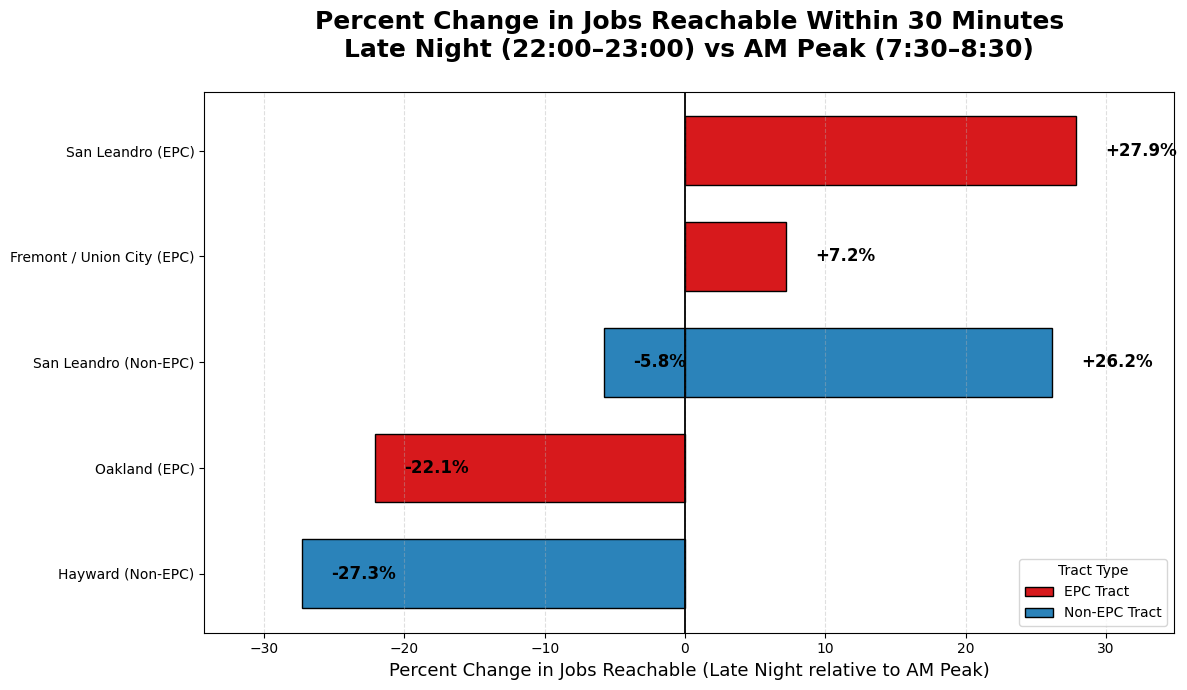

Saved to visualizations/job_access_change_bar_citynames.png


In [27]:
df = access_df.dropna(subset=["Δ_30min_%"]).copy()

# ensure EPC classification is consistent
df["is_epc"] = df["is_epc"].fillna(0).astype(int)
df["type"] = df["is_epc"].map({1: "EPC", 0: "Non-EPC"})

# merge city names
origins_subset = origins_sample[["GEOID", "city"]].copy()
origins_subset["GEOID"] = origins_subset["GEOID"].astype(str)

df = df.merge(origins_subset, left_on="origin_id", right_on="GEOID", how="left")

# final clean label for bar chart
df["label"] = df["city"] + " (" + df["type"] + ")"

# sort by percent change
df = df.sort_values("Δ_30min_%")

# colors
colors = df["type"].map({"EPC": "#d7191c", "Non-EPC": "#2b83ba"})

plt.figure(figsize=(12, 7))
bars = plt.barh(
    df["label"], df["Δ_30min_%"], color=colors, edgecolor="black", height=0.65
)

plt.title(
    "Percent Change in Jobs Reachable Within 30 Minutes\n"
    "Late Night (22:00–23:00) vs AM Peak (7:30–8:30)",
    fontsize=18,
    weight="bold",
    pad=25
)
plt.xlabel(
    "Percent Change in Jobs Reachable (Late Night relative to AM Peak)", fontsize=13
)

# zero reference line
plt.axvline(0, color="black", linewidth=1.3)

# dynamic x-limits so labels don't clip
min_val, max_val = df["Δ_30min_%"].min(), df["Δ_30min_%"].max()
buffer = max(abs(min_val), abs(max_val)) * 0.25
plt.xlim(min_val - buffer, max_val + buffer)

# annotate values
for bar in bars:
    w = bar.get_width()
    x_offset = 0.03 * (plt.xlim()[1] - plt.xlim()[0])
    plt.text(
        w + x_offset,
        bar.get_y() + bar.get_height() / 2,
        f"{w:+.1f}%",
        va="center",
        ha="left",
        fontsize=12,
        weight="bold",
    )

legend_handles = [
    Patch(facecolor="#d7191c", edgecolor="black", label="EPC Tract"),
    Patch(facecolor="#2b83ba", edgecolor="black", label="Non-EPC Tract"),
]
plt.legend(handles=legend_handles, title="Tract Type", loc="lower right")

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()

plt.savefig(VIS / "job_access_change_bar_citynames.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved to visualizations/job_access_change_bar_citynames.png")

<sup>**Note:** Percent changes shown here use the **30-minute threshold only**.  
Larger thresholds (e.g., 45 minutes in Section 8.7.2) naturally produce larger 
differences between AM and Late Night results, sometimes exceeding **+100%** — 
due to reduced congestion and improved late-night routing for longer trips.  
These higher values are expected and do not indicate inconsistency across visuals.</sup>

---

### 8.7.4 Final Paired Map (AM Peak Access vs. Late-Night Equity Impact)

This paired map provides a concise equity-focused comparison of transit job accessibility
for six representative Alameda County tracts (3 EPC, 3 non-EPC).

**Left map — AM Peak Job Access (7:30–8:30 AM):**  
Shows how many jobs each origin can reach within 30 minutes during the morning peak.
This highlights where job access is already strong under high-frequency service.

**Right map — Late-Night Impact (% Change vs AM Peak):**  
Shows how accessibility changes when transit service frequency drops at night
(22:00–23:00).  
- **Negative values (blue)** indicate substantial late-night losses  
- **Positive values (red)** reflect places where reduced congestion or routing
  efficiencies expand reach

**Why this matters:**  
Together, the maps show how *time-of-day transit performance* intersects with community
equity:  
- EPC origins, especially in **Oakland**, experience some of the sharpest late-night
  accessibility losses.  
- Some southern Alameda tracts gain reach after dark, suggesting structural
  differences in network performance and route dependence.  
- The comparison highlights where late-night reliability may be most critical from an
  equity perspective.

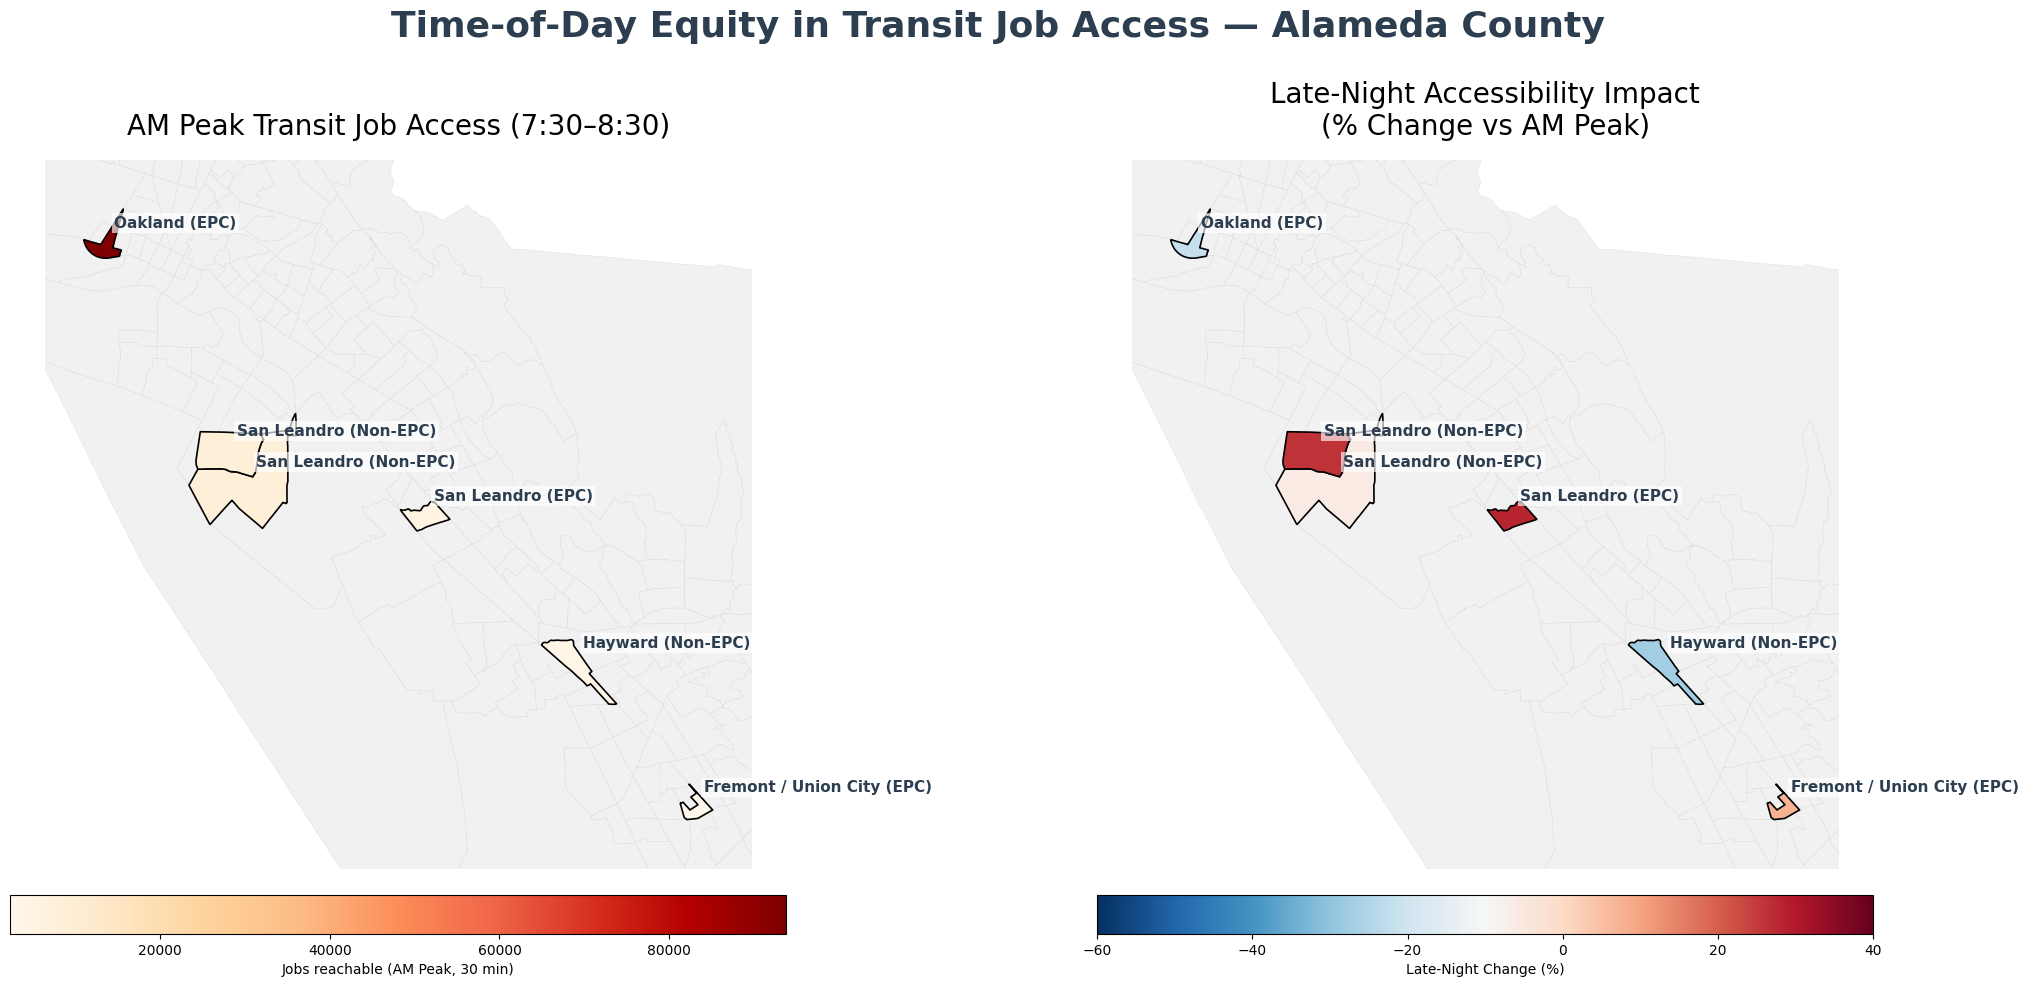

SAVED to visualizations/final_paired_map.png


In [28]:
# Load accessibility summary and ensure consistent IDs
access_df_fixed = pd.read_csv(PROCESSED / "job_accessibility_summary.csv")
access_df_fixed["origin_id"] = access_df_fixed["origin_id"].astype(str).str.zfill(11)

# Ensure origin sample has correct ID format and labeling
origins_plot = origins_sample.copy()
origins_plot["GEOID"] = origins_plot["GEOID"].astype(str).str.zfill(11)

# Merge AM Peak access + percent change metrics into origin geodata
origins_plot = (
    origins_plot.set_index("GEOID")
    .join(access_df_fixed.set_index("origin_id")[["jobs_am_peak_30min", "Δ_30min_%"]])
    .dropna(subset=["jobs_am_peak_30min"])
    .reset_index()
)

# Compute centroids in a projected CRS, then convert back to WGS84 for plotting
centroids_wgs84 = origins_plot.to_crs(
    "EPSG:26910"
).geometry.centroid.to_crs(  # UTM / projected  # safe centroid in meters
    "EPSG:4326"
)  # back to lon/lat
origins_plot["centroid"] = centroids_wgs84

# Load Alameda tracts for context/background
alameda_tracts = gpd.read_file(PROCESSED / "alameda_final.geojson").to_crs("EPSG:4326")

# Determine a map extent slightly zoomed around the six tracts
minx, miny, maxx, maxy = origins_plot.total_bounds
zoom_padding = 0.015
x0, x1 = minx - zoom_padding, maxx + zoom_padding
y0, y1 = miny - zoom_padding, maxy + zoom_padding

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# LEFT MAP (AM Peak Job Access)
alameda_tracts.plot(ax=ax1, color="#f1f1f1", edgecolor="#d0d0d0", linewidth=0.2)

origins_plot.plot(
    ax=ax1,
    column="jobs_am_peak_30min",
    cmap="OrRd",
    edgecolor="black",
    linewidth=1.2,
    legend=True,
    legend_kwds={
        "label": "Jobs reachable (AM Peak, 30 min)",
        "orientation": "horizontal",
        "shrink": 0.8,
        "pad": 0.03,
    },
)

ax1.set_xlim(x0, x1)
ax1.set_ylim(y0, y1)
ax1.set_title("AM Peak Transit Job Access (7:30–8:30)", fontsize=20, pad=18)
ax1.axis("off")

# Add automatically offset labels (AM Peak map)
offset_x = 0.003  # degrees — slightly to the right
offset_y = 0.004  # degrees — slightly upward

for _, row in origins_plot.iterrows():
    cx, cy = row["centroid"].x, row["centroid"].y
    ax1.text(
        cx + offset_x,
        cy + offset_y,
        row["pretty_name"],  # city + EPC label
        fontsize=11,
        ha="left",
        va="bottom",
        weight="bold",
        color="#2c3e50",
        bbox=dict(facecolor="white", alpha=0.65, edgecolor="none", pad=1.8),
    )

# RIGHT MAP (Percent Change Late Night vs AM Peak)
alameda_tracts.plot(ax=ax2, color="#f1f1f1", edgecolor="#d0d0d0", linewidth=0.2)

origins_plot.plot(
    ax=ax2,
    column="Δ_30min_%",
    cmap="RdBu_r",
    vmin=-60,
    vmax=40,
    edgecolor="black",
    linewidth=1.2,
    legend=True,
    legend_kwds={
        "label": "Late-Night Change (%)",
        "orientation": "horizontal",
        "shrink": 0.8,
        "pad": 0.03,
    },
)

ax2.set_xlim(x0, x1)
ax2.set_ylim(y0, y1)
ax2.set_title(
    "Late-Night Accessibility Impact\n(% Change vs AM Peak)",
    fontsize=20,
    pad=18,
)
ax2.axis("off")

# Add automatically offset labels (Late Night map)
for _, row in origins_plot.iterrows():
    cx, cy = row["centroid"].x, row["centroid"].y
    ax2.text(
        cx + offset_x,
        cy + offset_y,
        row["pretty_name"],
        fontsize=11,
        ha="left",
        va="bottom",
        weight="bold",
        color="#2c3e50",
        bbox=dict(facecolor="white", alpha=0.65, edgecolor="none", pad=1.8),
    )

plt.suptitle(
    "Time-of-Day Equity in Transit Job Access — Alameda County",
    fontsize=26,
    fontweight="bold",
    y=1.03,
    color="#2c3e50",
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(top=0.88, wspace=0.12)

plt.savefig(
    VIS / "final_paired_map.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="white",
)

plt.show()

print("SAVED to visualizations/final_paired_map.png")

<sup>**Note:** Percent-change values reflect the 30-minute accessibility window from the 
travel-time matrix (Section 8.6). Larger thresholds used elsewhere (e.g., 45 minutes in 
Section 8.7.2) naturally produce larger swings and may exceed ±100%. These patterns are 
expected and do not represent inconsistencies between visuals.</sup>

---

## 8.8 Final Findings & Interpretation (AM Peak vs Late Night)

The time-aware transit accessibility results reveal clear, time-dependent equity 
differences between EPC and non-EPC tracts once real transit schedules are included:

- **Late-night transit service significantly reduces job accessibility** for most origins, 
  with drops ranging from **–5% to –27%** in reachable jobs at the 30-minute threshold.

- **EPC origins experience the steepest losses**, especially in Oakland and Central/South 
  Alameda County, due to their reliance on high-frequency daytime service that does not 
  extend late into the evening.

- **A few non-EPC suburban tracts show modest increases** in late-night accessibility, 
  driven not by better transit supply but by reduced roadway congestion that speeds up 
  walk+transfer connections in mixed-mode routing.

- **Disparities widen at night**, meaning that EPC residents—who are more dependent on 
  transit—face disproportionately greater reductions in access to employment compared 
  with non-EPC residents.

These findings highlight that **time-of-day variation is itself an equity issue**. 
For workers with nontraditional or late-night schedules, reliable evening service 
is essential for maintaining access to economic opportunity.

----

## 8.9 Output Files for StoryMap & GitHub Pages

All processed datasets, isochrones, travel-time matrices, accessibility summaries, 
and visualizations generated in this notebook have been saved to the project folder 
structure.

**`data/processed/`**
- `travel_times_am_late.csv`
- `job_accessibility_summary.csv`
- `isochrones_am.geojson`
- `isochrones_late.geojson`

**`visualizations/`**
- `explorer_all_thresholds.html`
- `animated_accessibility_slider.html`
- `job_access_change_bar_citynames.png`
- `final_paired_map.png`

**`results/`**
- Intermediate analysis summaries for StoryMap integration.

These outputs provide all required inputs for the final StoryMap and GitHub Pages 
presentation.

---

## 9. Documentation & Data Dictionary

This section documents all variables produced in the Track B workflow.  
It includes core tract attributes, LODES-derived job metrics, R5 travel-time outputs,  
isochrone metadata, and final accessibility comparisons.

These fields appear in the cleaned datasets and intermediate tables used throughout  
the analysis and are exported to `docs/data_dictionary.txt` for the StoryMap.

| Column              | Description                                                       | Example        |
|---------------------|-------------------------------------------------------------------|----------------|
| **GEOID**           | Census tract ID (11-digit FIPS)                                   | 06001400100    |
| **is_epc**          | 1 if MTC Equity Priority Community; 0 otherwise                   | 0              |
| **population**      | ACS 2018–2022 total population                                    | 4,295          |
| **geometry**        | Census tract polygon geometry (EPSG:4326)                         | POLYGON(...)   |
| **jobs**            | LODES 2021 workplace jobs (C000, tract-level)                     | 12,521         |
| **jobs_30min**      | Pilot centroid-proxy 30-min job accessibility                     | 421,795        |
| **am_peak_min**     | R5 travel time in minutes (AM Peak 7:30–8:30 AM)                  | 34.0           |
| **late_night_min**  | R5 travel time in minutes (Late Night 22:00–23:00)                | 45.0           |
| **off_peak_delay_min** | Late Night – AM Peak travel time                               | 11.0           |
| **jobs_am_peak_15min** | Jobs reachable within 15 minutes (AM Peak)                     | 451            |
| **jobs_am_peak_30min** | Jobs reachable within 30 minutes (AM Peak)                     | 93,818         |
| **jobs_am_peak_45min** | Jobs reachable within 45 minutes (AM Peak)                     | 227,323        |
| **jobs_late_night_15min** | Jobs reachable within 15 minutes (Late Night)               | 451            |
| **jobs_late_night_30min** | Jobs reachable within 30 minutes (Late Night)               | 73,075         |
| **jobs_late_night_45min** | Jobs reachable within 45 minutes (Late Night)               | 164,564        |
| **Δ_15min_%**       | Percent change (Late vs AM, 15 min)                               | 0.0            |
| **Δ_30min_%**       | Percent change (Late vs AM, 30 min)                               | –22.1          |
| **Δ_45min_%**       | Percent change (Late vs AM, 45 min)                               | –27.6          |
| **city**            | Approximate city derived from centroid                            | Oakland        |
| **pretty_name**     | City label + EPC tag for visualization                            | Oakland (EPC)  |
| **minutes**         | Isochrone threshold (15, 30, 45)                                  | 30             |
| **period**          | Isochrone time period (“AM Peak” or “Late Night”)                 | AM Peak        |
| **origin_id**       | GEOID of isochrone origin                                         | 06001402200    |
| **origin_name**     | Label for origin tract                                            | 06001402200    |

**CRS Used:**  
- Spatial layer storage: **EPSG:4326 (WGS84)**  
- Distance computations: **EPSG:26910 (UTM Zone 10N)**  

In [29]:
# This file documents the fields produced in the final Track B workflow.

os.makedirs(DOCS, exist_ok=True)

with open(f"{DOCS}/data_dictionary.txt", "w") as f:
    f.write(
        """Column | Description | Example
---------|-------------|----------
GEOID | Census tract ID (11-digit FIPS) | 06001400100
is_epc | 1 if Equity Priority Community (MTC) | 0
population | ACS 2018–2022 population | 4295
geometry | Tract boundary (EPSG:4326) | POLYGON(...)

jobs | Total LODES 2021 workplace jobs (C000) | 12521

jobs_30min | Pilot metric: estimated jobs reachable in 30 min (centroid proxy) | 421795

am_peak_min | R5 travel time in minutes (AM Peak 7:30–8:30) | 34.0
late_night_min | R5 travel time in minutes (Late Night 22:00–23:00) | 45.0
off_peak_delay_min | Late Night minus AM Peak travel time | 11.0

jobs_am_peak_15min | Jobs reachable within 15 min during AM Peak | 451
jobs_am_peak_30min | Jobs reachable within 30 min during AM Peak | 93818
jobs_am_peak_45min | Jobs reachable within 45 min during AM Peak | 227323

jobs_late_night_15min | Jobs reachable within 15 min during Late Night | 451
jobs_late_night_30min | Jobs reachable within 30 min during Late Night | 73075
jobs_late_night_45min | Jobs reachable within 45 min during Late Night | 164564

Δ_15min_% | Percent change in job access (Late vs AM) | 0.0
Δ_30min_% | Percent change in job access (Late vs AM) | -22.1
Δ_45min_% | Percent change in job access (Late vs AM) | -27.6

city | Assigned city label based on centroid | Oakland
pretty_name | City plus EPC label | Oakland (EPC)

minutes | Isochrone threshold (15, 30, 45) | 30
period | Time period for isochrone (AM Peak or Late Night) | AM Peak

origin_id | GEOID of origin tract | 06001402200
origin_name | Name or label for origin tract | 06001402200
"""
    )

print("Saved data dictionary to docs/data_dictionary.txt")

Saved data dictionary to docs/data_dictionary.txt


---

## 12. References

- Metropolitan Transportation Commission (MTC): **Plan Bay Area 2050 EPC Dataset**
- U.S. Census Bureau: **TIGER/Line Shapefiles (2022)**, **ACS 2018–2022 5-Year Estimates**
- 511 SF Bay Open Data: **GTFS Feeds for AC Transit and BART**
- U.S. Census LEHD: **LODES Workplace Area Characteristics (WAC), 2021**
- OpenStreetMap Contributors: **OSM Street Network and Geodata**
- Geofabrik: **Northern California OSM Extract**
- **r5py Documentation** — https://r5py.readthedocs.io  
- Python Libraries: GeoPandas, pandas, NumPy, matplotlib, seaborn, folium, plotly

*All datasets and code used in this analysis are stored in the project repository under  
`data/raw/`, `data/processed/`, `visualizations/`, and `docs/` for transparency and reproducibility.*